In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera(nx, ny, input_calib_img_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(input_calib_img_path)
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1], gray.shape[0])
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = './debug_dir/01_corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(0)

    #cv2.destroyAllWindows()
    print('Found chess board corners: ', ret)
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return ret, mtx, dist

In [3]:
def correct_distortion(img, dst, mtx):
    dst = cv2.undistort(img, mtx, dst, None, mtx)
    return dst

In [4]:
# Binarization Pipeline
def binarization_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary.astype(np.int), s_binary.astype(np.int)))
    
    combined = np.zeros_like(sxbinary)    
    combined[((s_binary == 1) | (sxbinary == 1))] = 255
    
    return combined

In [88]:
def correct_perspective(undist):
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    print('image size: ', img_size)
    
    offset_x = 100
    offset_y = 0
    
    # For source points:  Manually setting four points by eye balling in staight image 'project_test1.jpg'.
 
    perspective_top_left     = (597, 454)
    perspective_top_right    = (700, 454)
    perspective_bottom_right = (1190, 720)
    perspective_bottom_left  = (260, 720)
   
    src = np.float32([perspective_top_left, perspective_top_right, perspective_bottom_right, perspective_bottom_left])
    
    
    orthographic_top_left      = (offset_x               , offset_y)
    orthographic_top_right     = (img_size[0] - offset_x , offset_y) 
    orthographic_bottom_right  = (img_size[0] - offset_x , img_size[1])
    orthographic_bottom_left   = (offset_x               , img_size[1])
    
    dst = np.float32([orthographic_top_left, orthographic_top_right, orthographic_bottom_right, orthographic_bottom_left])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if(show_debug_images == True):
        # Create an image to draw the lines on
        original_draw = np.zeros_like(undist).astype(np.uint8)
        orig_color = np.dstack((undist, original_draw, original_draw))
        
        cv2.line(orig_color,perspective_bottom_left, perspective_bottom_right, (0,0,255),2)
        cv2.line(orig_color,perspective_bottom_left, perspective_top_left, (0,0,255),2)
        cv2.line(orig_color,perspective_top_left, perspective_top_right, (0,0,255),2)
        cv2.line(orig_color,perspective_bottom_right, perspective_top_right, (0,0,255),2)
   
        #write_name = './debug_dir/03_warped_image'+str(0)+'.jpg'
        #cv2.imwrite(write_name, orig_color)

        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
    
        ax1.imshow(cv2.cvtColor(orig_color,cv2.COLOR_BGR2RGB))
        ax1.set_title('Corr- Orig Image', fontsize=30)
    
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Corr- warped Image', fontsize=30)
    
    
    return M, MInv, warped

In [75]:
def locate_lane_pos(binary_warped):
    # Assuming we have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if(show_debug_images == True):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(show_debug_images == True):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    
    return left_fit, right_fit

In [ ]:
def fit_poly(left_lane, right_lane):
    
    #ym_per_pix = 24/720 # meters per pixel in y dimension, assumming 8 blocks of 3 meters each
    #xm_per_pix = 3.7/780 # meteres per pixel in x dimension

    ym_per_pix = 1 # meters per pixel in y dimension, assumming 8 blocks of 3 meters each
    xm_per_pix = 1 # meteres per pixel in x dimension

    lefty  = left_lane[:, 1] * ym_per_pix
    leftx  = left_lane[:, 0] * xm_per_pix

    # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]

    righty = right_lane_list[:, 1] * ym_per_pix
    rightx = right_lane_list[:, 0] * xm_per_pix

    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    return left_fit,left_fitx,right_fit,right_fitx

In [116]:
def get_curvature_mt(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1000 # meters per pixel in x dimension

    #The last point where curvature would be evaluated
    y_eval = 720*ym_per_pix
    
    leftx = leftx*xm_per_pix;
    rightx = rightx*xm_per_pix;
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty, leftx, 2)
    right_fit_cr = np.polyfit(ploty, rightx, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [100]:
def process_image(input_image):
    undist = correct_distortion(input_image,dist_coff,cam_matrix)
    bin_img = binarization_pipeline(undist,(170,255),(20,100))
    M, MInv, warped = correct_perspective(bin_img)
    left_line, right_line = locate_lane_pos(warped)
    
    '''
    idx = 0
    write_name = './debug_dir/00_input_image.jpg'+str(idx)+'.jpg'
    cv2.imwrite(write_name, input_image)
    
    write_name = './debug_dir/01_undist_image'+str(idx)+'.jpg'
    cv2.imwrite(write_name, undist)
    
    write_name = './debug_dir/02_bin_image'+str(idx)+'.jpg'
    cv2.imwrite(write_name, bin_img)
    
    write_name = './debug_dir/04_warped_image'+str(idx)+'.jpg'
    cv2.imwrite(write_name, warped)
    '''
    
    img_size = (warped.shape[1], warped.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[1]-1, img_size[0] )
    
    left_fitx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    right_fitx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #write_name = './debug_dir/06_poly_image'+str(idx)+'.jpg'
    #cv2.imwrite(write_name, color_warp)
      
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, img_size) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #write_name = './debug_dir/07_final_image'+str(idx)+'.jpg'
    #cv2.imwrite(write_name, result)
    
    curv_rad_left, curv_rad_right = get_curvature_mt(left_fitx, right_fitx, ploty)
    
    if(show_debug_images == True): 
        # Visualize intermediate results
        f, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
        ax1.imshow(cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=30)
    
        ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=30)
    
        ax3.imshow(bin_img, cmap='gray')
        ax3.set_title('Bin image', fontsize=30)
    
        ax4.imshow(warped,cmap='gray')
        ax4.set_title('Warped', fontsize=30)
    
        ax5.imshow(cv2.cvtColor(color_warp,cv2.COLOR_BGR2RGB))
        ax5.set_title('color Warped', fontsize=30)
    
        ax6.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
        ax6.set_title('final result', fontsize=30)
    
    
    return result

In [58]:
# 1. Calibrate the camera using pre stored images of calibration pattern, ~20 images should be good.

nx = 9 # number of inner chess board corners in x direction
ny = 6 # number of inner chess board corners in y direction

re_proj_err, cam_matrix, dist_coff = calibrate_camera(nx, ny, 'camera_cal/calibration*.jpg')
print('Reprojection Error after calibration: ', re_proj_err)

Found chess board corners:  True
Reprojection Error after calibration:  1.1696553264915341


image size:  (1280, 720)
2011426.33168 m 9178345.9599 m


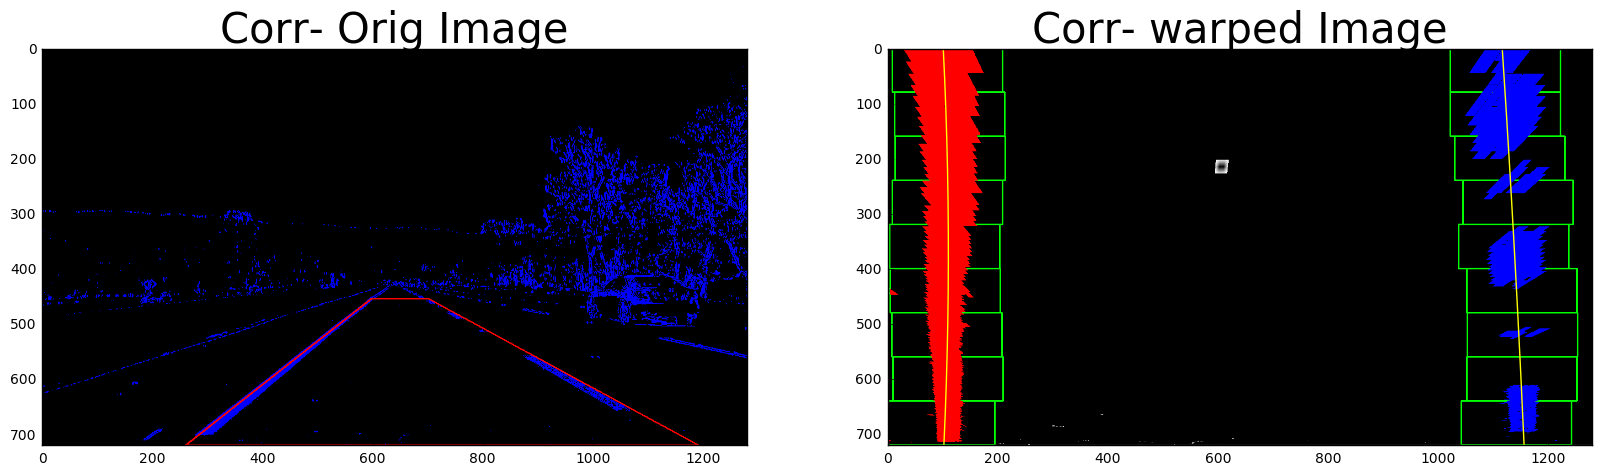

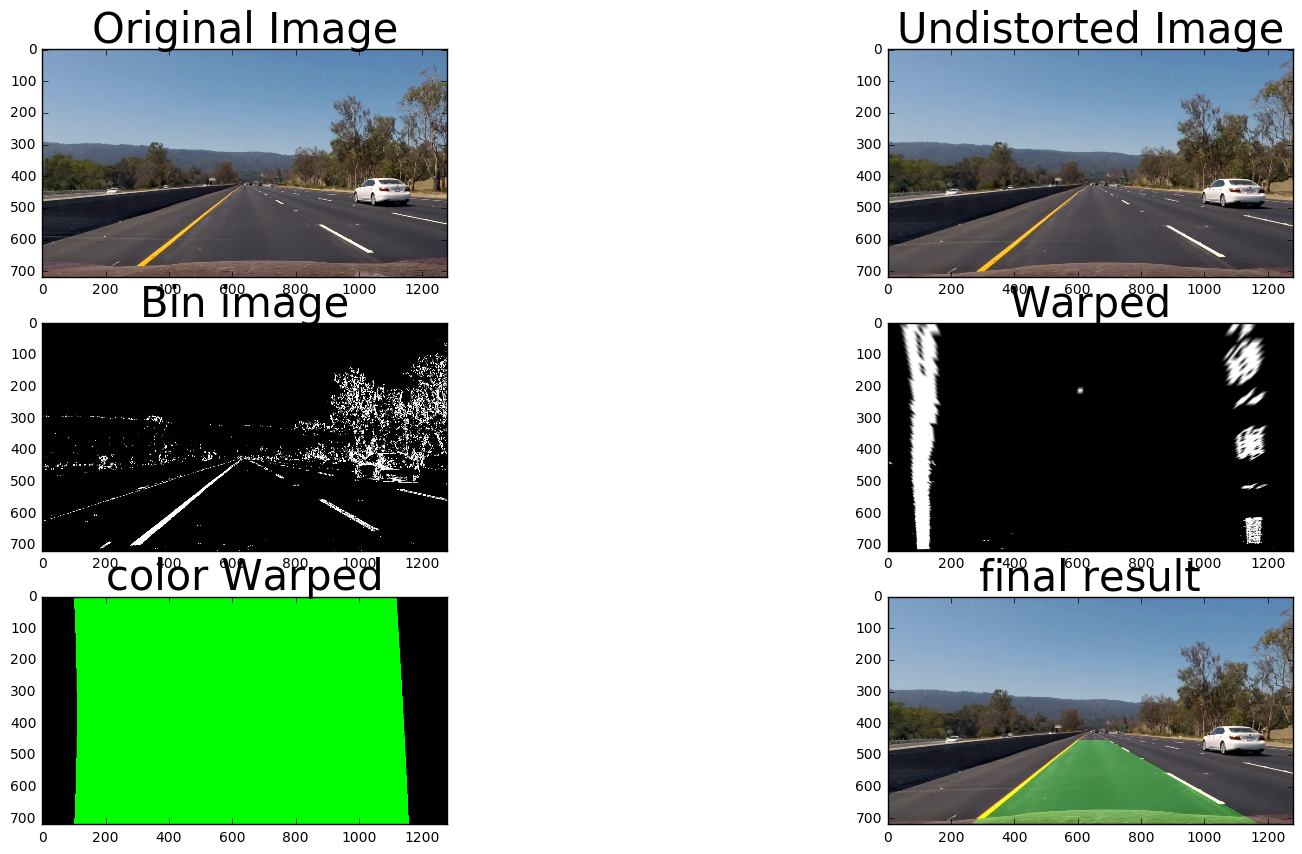

In [117]:
show_debug_images = True

input_img = cv2.imread('test_images/project_test1.jpg')
result = process_image(input_img)

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [65]:
video_output = 'project_video_out.mp4'
video_input  = VideoFileClip('project_video.mp4')
video_clip = video_input.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

image size:  (1280, 720)
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

image size:  (1280, 720)


  0%|                                         | 1/1261 [00:00<04:06,  5.10it/s]

image size:  (1280, 720)


  0%|                                         | 2/1261 [00:00<03:57,  5.30it/s]

image size:  (1280, 720)


  0%|                                         | 3/1261 [00:00<03:50,  5.47it/s]

image size:  (1280, 720)


  0%|▏                                        | 4/1261 [00:00<03:45,  5.57it/s]

image size:  (1280, 720)


  0%|▏                                        | 5/1261 [00:00<03:41,  5.67it/s]

image size:  (1280, 720)


  0%|▏                                        | 6/1261 [00:01<03:42,  5.64it/s]

image size:  (1280, 720)


  1%|▏                                        | 7/1261 [00:01<03:44,  5.60it/s]

image size:  (1280, 720)


  1%|▎                                        | 8/1261 [00:01<04:27,  4.68it/s]

image size:  (1280, 720)


  1%|▎                                        | 9/1261 [00:01<04:42,  4.44it/s]

image size:  (1280, 720)


  1%|▎                                       | 10/1261 [00:01<04:20,  4.80it/s]

image size:  (1280, 720)


  1%|▎                                       | 11/1261 [00:02<04:05,  5.09it/s]

image size:  (1280, 720)


  1%|▍                                       | 12/1261 [00:02<03:58,  5.23it/s]

image size:  (1280, 720)


  1%|▍                                       | 13/1261 [00:02<03:51,  5.38it/s]

image size:  (1280, 720)


  1%|▍                                       | 14/1261 [00:02<03:47,  5.48it/s]

image size:  (1280, 720)


  1%|▍                                       | 15/1261 [00:02<03:43,  5.56it/s]

image size:  (1280, 720)


  1%|▌                                       | 16/1261 [00:03<03:46,  5.51it/s]

image size:  (1280, 720)


  1%|▌                                       | 17/1261 [00:03<03:42,  5.59it/s]

image size:  (1280, 720)


  1%|▌                                       | 18/1261 [00:03<03:39,  5.67it/s]

image size:  (1280, 720)


  2%|▌                                       | 19/1261 [00:03<03:35,  5.75it/s]

image size:  (1280, 720)


  2%|▋                                       | 20/1261 [00:03<03:34,  5.79it/s]

image size:  (1280, 720)


  2%|▋                                       | 21/1261 [00:03<03:31,  5.86it/s]

image size:  (1280, 720)


  2%|▋                                       | 22/1261 [00:04<03:34,  5.76it/s]

image size:  (1280, 720)


  2%|▋                                       | 23/1261 [00:04<03:34,  5.78it/s]

image size:  (1280, 720)


  2%|▊                                       | 24/1261 [00:04<03:35,  5.74it/s]

image size:  (1280, 720)


  2%|▊                                       | 25/1261 [00:04<03:35,  5.74it/s]

image size:  (1280, 720)


  2%|▊                                       | 26/1261 [00:04<03:35,  5.73it/s]

image size:  (1280, 720)


  2%|▊                                       | 27/1261 [00:04<03:35,  5.73it/s]

image size:  (1280, 720)


  2%|▉                                       | 28/1261 [00:05<03:35,  5.72it/s]

image size:  (1280, 720)


  2%|▉                                       | 29/1261 [00:05<04:34,  4.48it/s]

image size:  (1280, 720)


  2%|▉                                       | 30/1261 [00:05<04:51,  4.23it/s]

image size:  (1280, 720)


  2%|▉                                       | 31/1261 [00:05<04:37,  4.43it/s]

image size:  (1280, 720)


  3%|█                                       | 32/1261 [00:06<04:20,  4.71it/s]

image size:  (1280, 720)


  3%|█                                       | 33/1261 [00:06<04:10,  4.89it/s]

image size:  (1280, 720)


  3%|█                                       | 34/1261 [00:06<04:37,  4.43it/s]

image size:  (1280, 720)


  3%|█                                       | 35/1261 [00:06<04:46,  4.28it/s]

image size:  (1280, 720)


  3%|█▏                                      | 36/1261 [00:06<04:26,  4.60it/s]

image size:  (1280, 720)


  3%|█▏                                      | 37/1261 [00:07<04:30,  4.53it/s]

image size:  (1280, 720)


  3%|█▏                                      | 38/1261 [00:07<04:55,  4.14it/s]

image size:  (1280, 720)


  3%|█▏                                      | 39/1261 [00:07<04:29,  4.54it/s]

image size:  (1280, 720)


  3%|█▎                                      | 40/1261 [00:07<04:02,  5.03it/s]

image size:  (1280, 720)


  3%|█▎                                      | 41/1261 [00:07<03:48,  5.35it/s]

image size:  (1280, 720)


  3%|█▎                                      | 42/1261 [00:08<03:36,  5.63it/s]

image size:  (1280, 720)


  3%|█▎                                      | 43/1261 [00:08<03:39,  5.56it/s]

image size:  (1280, 720)


  3%|█▍                                      | 44/1261 [00:08<03:37,  5.58it/s]

image size:  (1280, 720)


  4%|█▍                                      | 45/1261 [00:08<03:32,  5.71it/s]

image size:  (1280, 720)


  4%|█▍                                      | 46/1261 [00:08<03:26,  5.88it/s]

image size:  (1280, 720)


  4%|█▍                                      | 47/1261 [00:08<03:24,  5.95it/s]

image size:  (1280, 720)


  4%|█▌                                      | 48/1261 [00:09<03:25,  5.89it/s]

image size:  (1280, 720)


  4%|█▌                                      | 49/1261 [00:09<03:30,  5.76it/s]

image size:  (1280, 720)


  4%|█▌                                      | 50/1261 [00:09<03:31,  5.72it/s]

image size:  (1280, 720)


  4%|█▌                                      | 51/1261 [00:09<03:29,  5.76it/s]

image size:  (1280, 720)


  4%|█▋                                      | 52/1261 [00:09<03:31,  5.73it/s]

image size:  (1280, 720)


  4%|█▋                                      | 53/1261 [00:10<03:32,  5.70it/s]

image size:  (1280, 720)


  4%|█▋                                      | 54/1261 [00:10<03:34,  5.61it/s]

image size:  (1280, 720)


  4%|█▋                                      | 55/1261 [00:10<03:38,  5.52it/s]

image size:  (1280, 720)


  4%|█▊                                      | 56/1261 [00:10<03:33,  5.64it/s]

image size:  (1280, 720)


  5%|█▊                                      | 57/1261 [00:10<03:34,  5.62it/s]

image size:  (1280, 720)


  5%|█▊                                      | 58/1261 [00:10<03:31,  5.68it/s]

image size:  (1280, 720)


  5%|█▊                                      | 59/1261 [00:11<03:33,  5.63it/s]

image size:  (1280, 720)


  5%|█▉                                      | 60/1261 [00:11<03:57,  5.05it/s]

image size:  (1280, 720)


  5%|█▉                                      | 61/1261 [00:11<04:06,  4.87it/s]

image size:  (1280, 720)


  5%|█▉                                      | 62/1261 [00:11<03:55,  5.09it/s]

image size:  (1280, 720)


  5%|█▉                                      | 63/1261 [00:11<03:46,  5.30it/s]

image size:  (1280, 720)


  5%|██                                      | 64/1261 [00:12<03:39,  5.46it/s]

image size:  (1280, 720)


  5%|██                                      | 65/1261 [00:12<03:37,  5.50it/s]

image size:  (1280, 720)


  5%|██                                      | 66/1261 [00:12<03:33,  5.61it/s]

image size:  (1280, 720)


  5%|██▏                                     | 67/1261 [00:12<03:31,  5.64it/s]

image size:  (1280, 720)


  5%|██▏                                     | 68/1261 [00:12<03:34,  5.56it/s]

image size:  (1280, 720)


  5%|██▏                                     | 69/1261 [00:12<03:34,  5.57it/s]

image size:  (1280, 720)


  6%|██▏                                     | 70/1261 [00:13<03:30,  5.65it/s]

image size:  (1280, 720)


  6%|██▎                                     | 71/1261 [00:13<03:29,  5.67it/s]

image size:  (1280, 720)


  6%|██▎                                     | 72/1261 [00:13<03:32,  5.60it/s]

image size:  (1280, 720)


  6%|██▎                                     | 73/1261 [00:13<03:29,  5.68it/s]

image size:  (1280, 720)


  6%|██▎                                     | 74/1261 [00:13<03:27,  5.73it/s]

image size:  (1280, 720)


  6%|██▍                                     | 75/1261 [00:14<03:28,  5.68it/s]

image size:  (1280, 720)


  6%|██▍                                     | 76/1261 [00:14<03:30,  5.63it/s]

image size:  (1280, 720)


  6%|██▍                                     | 77/1261 [00:14<03:31,  5.59it/s]

image size:  (1280, 720)


  6%|██▍                                     | 78/1261 [00:14<03:34,  5.50it/s]

image size:  (1280, 720)


  6%|██▌                                     | 79/1261 [00:14<03:33,  5.53it/s]

image size:  (1280, 720)


  6%|██▌                                     | 80/1261 [00:14<03:31,  5.59it/s]

image size:  (1280, 720)


  6%|██▌                                     | 81/1261 [00:15<03:28,  5.65it/s]

image size:  (1280, 720)


  7%|██▌                                     | 82/1261 [00:15<03:28,  5.66it/s]

image size:  (1280, 720)


  7%|██▋                                     | 83/1261 [00:15<03:24,  5.75it/s]

image size:  (1280, 720)


  7%|██▋                                     | 84/1261 [00:15<03:26,  5.69it/s]

image size:  (1280, 720)


  7%|██▋                                     | 85/1261 [00:15<03:22,  5.80it/s]

image size:  (1280, 720)


  7%|██▋                                     | 86/1261 [00:15<03:25,  5.71it/s]

image size:  (1280, 720)


  7%|██▊                                     | 87/1261 [00:16<03:23,  5.78it/s]

image size:  (1280, 720)


  7%|██▊                                     | 88/1261 [00:16<03:24,  5.73it/s]

image size:  (1280, 720)


  7%|██▊                                     | 89/1261 [00:16<03:25,  5.71it/s]

image size:  (1280, 720)


  7%|██▊                                     | 90/1261 [00:16<03:30,  5.57it/s]

image size:  (1280, 720)


  7%|██▉                                     | 91/1261 [00:16<03:30,  5.55it/s]

image size:  (1280, 720)


  7%|██▉                                     | 92/1261 [00:17<03:30,  5.54it/s]

image size:  (1280, 720)


  7%|██▉                                     | 93/1261 [00:17<03:30,  5.55it/s]

image size:  (1280, 720)


  7%|██▉                                     | 94/1261 [00:17<03:29,  5.58it/s]

image size:  (1280, 720)


  8%|███                                     | 95/1261 [00:17<03:31,  5.52it/s]

image size:  (1280, 720)


  8%|███                                     | 96/1261 [00:17<03:35,  5.41it/s]

image size:  (1280, 720)


  8%|███                                     | 97/1261 [00:17<03:31,  5.50it/s]

image size:  (1280, 720)


  8%|███                                     | 98/1261 [00:18<03:28,  5.57it/s]

image size:  (1280, 720)


  8%|███▏                                    | 99/1261 [00:18<03:27,  5.61it/s]

image size:  (1280, 720)


  8%|███                                    | 100/1261 [00:18<03:27,  5.60it/s]

image size:  (1280, 720)


  8%|███                                    | 101/1261 [00:18<03:23,  5.70it/s]

image size:  (1280, 720)


  8%|███▏                                   | 102/1261 [00:18<03:24,  5.67it/s]

image size:  (1280, 720)


  8%|███▏                                   | 103/1261 [00:19<03:22,  5.72it/s]

image size:  (1280, 720)


  8%|███▏                                   | 104/1261 [00:19<03:21,  5.74it/s]

image size:  (1280, 720)


  8%|███▏                                   | 105/1261 [00:19<03:20,  5.76it/s]

image size:  (1280, 720)


  8%|███▎                                   | 106/1261 [00:19<03:19,  5.78it/s]

image size:  (1280, 720)


  8%|███▎                                   | 107/1261 [00:19<03:22,  5.70it/s]

image size:  (1280, 720)


  9%|███▎                                   | 108/1261 [00:19<03:21,  5.71it/s]

image size:  (1280, 720)


  9%|███▎                                   | 109/1261 [00:20<03:19,  5.77it/s]

image size:  (1280, 720)


  9%|███▍                                   | 110/1261 [00:20<03:20,  5.75it/s]

image size:  (1280, 720)


  9%|███▍                                   | 111/1261 [00:20<03:20,  5.74it/s]

image size:  (1280, 720)


  9%|███▍                                   | 112/1261 [00:20<03:20,  5.73it/s]

image size:  (1280, 720)


  9%|███▍                                   | 113/1261 [00:20<03:19,  5.75it/s]

image size:  (1280, 720)


  9%|███▌                                   | 114/1261 [00:20<03:21,  5.68it/s]

image size:  (1280, 720)


  9%|███▌                                   | 115/1261 [00:21<03:20,  5.73it/s]

image size:  (1280, 720)


  9%|███▌                                   | 116/1261 [00:21<03:21,  5.69it/s]

image size:  (1280, 720)


  9%|███▌                                   | 117/1261 [00:21<03:21,  5.66it/s]

image size:  (1280, 720)


  9%|███▋                                   | 118/1261 [00:21<03:25,  5.57it/s]

image size:  (1280, 720)


  9%|███▋                                   | 119/1261 [00:21<03:24,  5.59it/s]

image size:  (1280, 720)


 10%|███▋                                   | 120/1261 [00:21<03:21,  5.65it/s]

image size:  (1280, 720)


 10%|███▋                                   | 121/1261 [00:22<03:21,  5.66it/s]

image size:  (1280, 720)


 10%|███▊                                   | 122/1261 [00:22<03:20,  5.67it/s]

image size:  (1280, 720)


 10%|███▊                                   | 123/1261 [00:22<03:19,  5.71it/s]

image size:  (1280, 720)


 10%|███▊                                   | 124/1261 [00:22<03:19,  5.71it/s]

image size:  (1280, 720)


 10%|███▊                                   | 125/1261 [00:22<03:17,  5.74it/s]

image size:  (1280, 720)


 10%|███▉                                   | 126/1261 [00:23<03:17,  5.73it/s]

image size:  (1280, 720)


 10%|███▉                                   | 127/1261 [00:23<03:19,  5.68it/s]

image size:  (1280, 720)


 10%|███▉                                   | 128/1261 [00:23<03:18,  5.71it/s]

image size:  (1280, 720)


 10%|███▉                                   | 129/1261 [00:23<03:18,  5.71it/s]

image size:  (1280, 720)


 10%|████                                   | 130/1261 [00:23<03:19,  5.68it/s]

image size:  (1280, 720)


 10%|████                                   | 131/1261 [00:23<03:18,  5.70it/s]

image size:  (1280, 720)


 10%|████                                   | 132/1261 [00:24<03:22,  5.58it/s]

image size:  (1280, 720)


 11%|████                                   | 133/1261 [00:24<03:25,  5.49it/s]

image size:  (1280, 720)


 11%|████▏                                  | 134/1261 [00:24<03:31,  5.32it/s]

image size:  (1280, 720)


 11%|████▏                                  | 135/1261 [00:24<03:37,  5.18it/s]

image size:  (1280, 720)


 11%|████▏                                  | 136/1261 [00:24<03:37,  5.17it/s]

image size:  (1280, 720)


 11%|████▏                                  | 137/1261 [00:25<03:36,  5.20it/s]

image size:  (1280, 720)


 11%|████▎                                  | 138/1261 [00:25<03:39,  5.11it/s]

image size:  (1280, 720)


 11%|████▎                                  | 139/1261 [00:25<03:35,  5.22it/s]

image size:  (1280, 720)


 11%|████▎                                  | 140/1261 [00:25<03:37,  5.15it/s]

image size:  (1280, 720)


 11%|████▎                                  | 141/1261 [00:25<03:38,  5.12it/s]

image size:  (1280, 720)


 11%|████▍                                  | 142/1261 [00:26<03:40,  5.08it/s]

image size:  (1280, 720)


 11%|████▍                                  | 143/1261 [00:26<03:32,  5.25it/s]

image size:  (1280, 720)


 11%|████▍                                  | 144/1261 [00:26<03:35,  5.17it/s]

image size:  (1280, 720)


 11%|████▍                                  | 145/1261 [00:26<03:35,  5.17it/s]

image size:  (1280, 720)


 12%|████▌                                  | 146/1261 [00:26<03:33,  5.22it/s]

image size:  (1280, 720)


 12%|████▌                                  | 147/1261 [00:27<03:36,  5.14it/s]

image size:  (1280, 720)


 12%|████▌                                  | 148/1261 [00:27<03:38,  5.10it/s]

image size:  (1280, 720)


 12%|████▌                                  | 149/1261 [00:27<03:33,  5.21it/s]

image size:  (1280, 720)


 12%|████▋                                  | 150/1261 [00:27<03:28,  5.33it/s]

image size:  (1280, 720)


 12%|████▋                                  | 151/1261 [00:27<03:30,  5.27it/s]

image size:  (1280, 720)


 12%|████▋                                  | 152/1261 [00:27<03:32,  5.22it/s]

image size:  (1280, 720)


 12%|████▋                                  | 153/1261 [00:28<03:34,  5.18it/s]

image size:  (1280, 720)


 12%|████▊                                  | 154/1261 [00:28<03:28,  5.30it/s]

image size:  (1280, 720)


 12%|████▊                                  | 155/1261 [00:28<03:26,  5.36it/s]

image size:  (1280, 720)


 12%|████▊                                  | 156/1261 [00:28<03:27,  5.33it/s]

image size:  (1280, 720)


 12%|████▊                                  | 157/1261 [00:28<03:26,  5.33it/s]

image size:  (1280, 720)


 13%|████▉                                  | 158/1261 [00:29<03:29,  5.26it/s]

image size:  (1280, 720)


 13%|████▉                                  | 159/1261 [00:29<03:27,  5.31it/s]

image size:  (1280, 720)


 13%|████▉                                  | 160/1261 [00:29<03:22,  5.44it/s]

image size:  (1280, 720)


 13%|████▉                                  | 161/1261 [00:29<03:19,  5.50it/s]

image size:  (1280, 720)


 13%|█████                                  | 162/1261 [00:29<03:22,  5.42it/s]

image size:  (1280, 720)


 13%|█████                                  | 163/1261 [00:30<03:18,  5.52it/s]

image size:  (1280, 720)


 13%|█████                                  | 164/1261 [00:30<03:18,  5.52it/s]

image size:  (1280, 720)


 13%|█████                                  | 165/1261 [00:30<03:15,  5.61it/s]

image size:  (1280, 720)


 13%|█████▏                                 | 166/1261 [00:30<03:12,  5.69it/s]

image size:  (1280, 720)


 13%|█████▏                                 | 167/1261 [00:30<03:10,  5.74it/s]

image size:  (1280, 720)


 13%|█████▏                                 | 168/1261 [00:30<03:13,  5.64it/s]

image size:  (1280, 720)


 13%|█████▏                                 | 169/1261 [00:31<03:11,  5.69it/s]

image size:  (1280, 720)


 13%|█████▎                                 | 170/1261 [00:31<03:12,  5.66it/s]

image size:  (1280, 720)


 14%|█████▎                                 | 171/1261 [00:31<03:10,  5.72it/s]

image size:  (1280, 720)


 14%|█████▎                                 | 172/1261 [00:31<03:10,  5.73it/s]

image size:  (1280, 720)


 14%|█████▎                                 | 173/1261 [00:31<03:06,  5.84it/s]

image size:  (1280, 720)


 14%|█████▍                                 | 174/1261 [00:31<03:08,  5.76it/s]

image size:  (1280, 720)


 14%|█████▍                                 | 175/1261 [00:32<03:06,  5.82it/s]

image size:  (1280, 720)


 14%|█████▍                                 | 176/1261 [00:32<03:07,  5.78it/s]

image size:  (1280, 720)


 14%|█████▍                                 | 177/1261 [00:32<03:08,  5.76it/s]

image size:  (1280, 720)


 14%|█████▌                                 | 178/1261 [00:32<03:09,  5.73it/s]

image size:  (1280, 720)


 14%|█████▌                                 | 179/1261 [00:32<03:07,  5.78it/s]

image size:  (1280, 720)


 14%|█████▌                                 | 180/1261 [00:32<03:07,  5.76it/s]

image size:  (1280, 720)


 14%|█████▌                                 | 181/1261 [00:33<03:08,  5.74it/s]

image size:  (1280, 720)


 14%|█████▋                                 | 182/1261 [00:33<03:05,  5.82it/s]

image size:  (1280, 720)


 15%|█████▋                                 | 183/1261 [00:33<03:04,  5.83it/s]

image size:  (1280, 720)


 15%|█████▋                                 | 184/1261 [00:33<03:04,  5.84it/s]

image size:  (1280, 720)


 15%|█████▋                                 | 185/1261 [00:33<03:06,  5.75it/s]

image size:  (1280, 720)


 15%|█████▊                                 | 186/1261 [00:33<03:07,  5.72it/s]

image size:  (1280, 720)


 15%|█████▊                                 | 187/1261 [00:34<03:09,  5.67it/s]

image size:  (1280, 720)


 15%|█████▊                                 | 188/1261 [00:34<03:09,  5.66it/s]

image size:  (1280, 720)


 15%|█████▊                                 | 189/1261 [00:34<03:10,  5.63it/s]

image size:  (1280, 720)


 15%|█████▉                                 | 190/1261 [00:34<03:08,  5.69it/s]

image size:  (1280, 720)


 15%|█████▉                                 | 191/1261 [00:34<03:05,  5.76it/s]

image size:  (1280, 720)


 15%|█████▉                                 | 192/1261 [00:35<03:04,  5.80it/s]

image size:  (1280, 720)


 15%|█████▉                                 | 193/1261 [00:35<03:04,  5.79it/s]

image size:  (1280, 720)


 15%|██████                                 | 194/1261 [00:35<03:06,  5.72it/s]

image size:  (1280, 720)


 15%|██████                                 | 195/1261 [00:35<03:05,  5.75it/s]

image size:  (1280, 720)


 16%|██████                                 | 196/1261 [00:35<03:09,  5.61it/s]

image size:  (1280, 720)


 16%|██████                                 | 197/1261 [00:35<03:09,  5.61it/s]

image size:  (1280, 720)


 16%|██████                                 | 198/1261 [00:36<03:07,  5.66it/s]

image size:  (1280, 720)


 16%|██████▏                                | 199/1261 [00:36<03:07,  5.68it/s]

image size:  (1280, 720)


 16%|██████▏                                | 200/1261 [00:36<03:05,  5.72it/s]

image size:  (1280, 720)


 16%|██████▏                                | 201/1261 [00:36<03:05,  5.72it/s]

image size:  (1280, 720)


 16%|██████▏                                | 202/1261 [00:36<03:06,  5.68it/s]

image size:  (1280, 720)


 16%|██████▎                                | 203/1261 [00:36<03:06,  5.68it/s]

image size:  (1280, 720)


 16%|██████▎                                | 204/1261 [00:37<03:10,  5.55it/s]

image size:  (1280, 720)


 16%|██████▎                                | 205/1261 [00:37<03:07,  5.64it/s]

image size:  (1280, 720)


 16%|██████▎                                | 206/1261 [00:37<03:07,  5.63it/s]

image size:  (1280, 720)


 16%|██████▍                                | 207/1261 [00:37<03:04,  5.71it/s]

image size:  (1280, 720)


 16%|██████▍                                | 208/1261 [00:37<03:04,  5.71it/s]

image size:  (1280, 720)


 17%|██████▍                                | 209/1261 [00:38<03:06,  5.65it/s]

image size:  (1280, 720)


 17%|██████▍                                | 210/1261 [00:38<03:04,  5.68it/s]

image size:  (1280, 720)


 17%|██████▌                                | 211/1261 [00:38<03:03,  5.72it/s]

image size:  (1280, 720)


 17%|██████▌                                | 212/1261 [00:38<03:01,  5.77it/s]

image size:  (1280, 720)


 17%|██████▌                                | 213/1261 [00:38<03:02,  5.75it/s]

image size:  (1280, 720)


 17%|██████▌                                | 214/1261 [00:38<03:03,  5.69it/s]

image size:  (1280, 720)


 17%|██████▋                                | 215/1261 [00:39<03:02,  5.72it/s]

image size:  (1280, 720)


 17%|██████▋                                | 216/1261 [00:39<03:04,  5.67it/s]

image size:  (1280, 720)


 17%|██████▋                                | 217/1261 [00:39<03:03,  5.69it/s]

image size:  (1280, 720)


 17%|██████▋                                | 218/1261 [00:39<02:59,  5.80it/s]

image size:  (1280, 720)


 17%|██████▊                                | 219/1261 [00:39<02:56,  5.89it/s]

image size:  (1280, 720)


 17%|██████▊                                | 220/1261 [00:39<02:59,  5.79it/s]

image size:  (1280, 720)


 18%|██████▊                                | 221/1261 [00:40<02:57,  5.87it/s]

image size:  (1280, 720)


 18%|██████▊                                | 222/1261 [00:40<02:58,  5.83it/s]

image size:  (1280, 720)


 18%|██████▉                                | 223/1261 [00:40<02:58,  5.82it/s]

image size:  (1280, 720)


 18%|██████▉                                | 224/1261 [00:40<02:54,  5.93it/s]

image size:  (1280, 720)


 18%|██████▉                                | 225/1261 [00:40<02:55,  5.89it/s]

image size:  (1280, 720)


 18%|██████▉                                | 226/1261 [00:40<02:57,  5.83it/s]

image size:  (1280, 720)


 18%|███████                                | 227/1261 [00:41<02:59,  5.77it/s]

image size:  (1280, 720)


 18%|███████                                | 228/1261 [00:41<02:59,  5.77it/s]

image size:  (1280, 720)


 18%|███████                                | 229/1261 [00:41<02:57,  5.83it/s]

image size:  (1280, 720)


 18%|███████                                | 230/1261 [00:41<02:57,  5.82it/s]

image size:  (1280, 720)


 18%|███████▏                               | 231/1261 [00:41<02:57,  5.81it/s]

image size:  (1280, 720)


 18%|███████▏                               | 232/1261 [00:42<02:57,  5.80it/s]

image size:  (1280, 720)


 18%|███████▏                               | 233/1261 [00:42<03:01,  5.65it/s]

image size:  (1280, 720)


 19%|███████▏                               | 234/1261 [00:42<03:00,  5.70it/s]

image size:  (1280, 720)


 19%|███████▎                               | 235/1261 [00:42<02:57,  5.78it/s]

image size:  (1280, 720)


 19%|███████▎                               | 236/1261 [00:42<02:55,  5.83it/s]

image size:  (1280, 720)


 19%|███████▎                               | 237/1261 [00:42<02:55,  5.84it/s]

image size:  (1280, 720)


 19%|███████▎                               | 238/1261 [00:43<03:01,  5.63it/s]

image size:  (1280, 720)


 19%|███████▍                               | 239/1261 [00:43<02:58,  5.73it/s]

image size:  (1280, 720)


 19%|███████▍                               | 240/1261 [00:43<03:00,  5.66it/s]

image size:  (1280, 720)


 19%|███████▍                               | 241/1261 [00:43<02:58,  5.72it/s]

image size:  (1280, 720)


 19%|███████▍                               | 242/1261 [00:43<02:57,  5.75it/s]

image size:  (1280, 720)


 19%|███████▌                               | 243/1261 [00:43<02:58,  5.70it/s]

image size:  (1280, 720)


 19%|███████▌                               | 244/1261 [00:44<02:56,  5.77it/s]

image size:  (1280, 720)


 19%|███████▌                               | 245/1261 [00:44<02:55,  5.78it/s]

image size:  (1280, 720)


 20%|███████▌                               | 246/1261 [00:44<02:56,  5.76it/s]

image size:  (1280, 720)


 20%|███████▋                               | 247/1261 [00:44<02:51,  5.90it/s]

image size:  (1280, 720)


 20%|███████▋                               | 248/1261 [00:44<02:50,  5.96it/s]

image size:  (1280, 720)


 20%|███████▋                               | 249/1261 [00:44<02:53,  5.84it/s]

image size:  (1280, 720)


 20%|███████▋                               | 250/1261 [00:45<02:50,  5.94it/s]

image size:  (1280, 720)


 20%|███████▊                               | 251/1261 [00:45<02:54,  5.78it/s]

image size:  (1280, 720)


 20%|███████▊                               | 252/1261 [00:45<02:56,  5.73it/s]

image size:  (1280, 720)


 20%|███████▊                               | 253/1261 [00:45<02:54,  5.77it/s]

image size:  (1280, 720)


 20%|███████▊                               | 254/1261 [00:45<02:51,  5.86it/s]

image size:  (1280, 720)


 20%|███████▉                               | 255/1261 [00:45<02:50,  5.90it/s]

image size:  (1280, 720)


 20%|███████▉                               | 256/1261 [00:46<02:53,  5.79it/s]

image size:  (1280, 720)


 20%|███████▉                               | 257/1261 [00:46<02:53,  5.79it/s]

image size:  (1280, 720)


 20%|███████▉                               | 258/1261 [00:46<02:58,  5.62it/s]

image size:  (1280, 720)


 21%|████████                               | 259/1261 [00:46<02:57,  5.64it/s]

image size:  (1280, 720)


 21%|████████                               | 260/1261 [00:46<02:53,  5.77it/s]

image size:  (1280, 720)


 21%|████████                               | 261/1261 [00:47<02:54,  5.73it/s]

image size:  (1280, 720)


 21%|████████                               | 262/1261 [00:47<02:55,  5.69it/s]

image size:  (1280, 720)


 21%|████████▏                              | 263/1261 [00:47<02:54,  5.72it/s]

image size:  (1280, 720)


 21%|████████▏                              | 264/1261 [00:47<02:54,  5.70it/s]

image size:  (1280, 720)


 21%|████████▏                              | 265/1261 [00:47<02:55,  5.68it/s]

image size:  (1280, 720)


 21%|████████▏                              | 266/1261 [00:47<02:53,  5.74it/s]

image size:  (1280, 720)


 21%|████████▎                              | 267/1261 [00:48<02:54,  5.71it/s]

image size:  (1280, 720)


 21%|████████▎                              | 268/1261 [00:48<02:53,  5.71it/s]

image size:  (1280, 720)


 21%|████████▎                              | 269/1261 [00:48<02:54,  5.68it/s]

image size:  (1280, 720)


 21%|████████▎                              | 270/1261 [00:48<02:55,  5.63it/s]

image size:  (1280, 720)


 21%|████████▍                              | 271/1261 [00:48<02:54,  5.66it/s]

image size:  (1280, 720)


 22%|████████▍                              | 272/1261 [00:48<02:53,  5.68it/s]

image size:  (1280, 720)


 22%|████████▍                              | 273/1261 [00:49<02:52,  5.73it/s]

image size:  (1280, 720)


 22%|████████▍                              | 274/1261 [00:49<02:56,  5.58it/s]

image size:  (1280, 720)


 22%|████████▌                              | 275/1261 [00:49<02:53,  5.69it/s]

image size:  (1280, 720)


 22%|████████▌                              | 276/1261 [00:49<02:52,  5.72it/s]

image size:  (1280, 720)


 22%|████████▌                              | 277/1261 [00:49<02:50,  5.75it/s]

image size:  (1280, 720)


 22%|████████▌                              | 278/1261 [00:50<02:50,  5.75it/s]

image size:  (1280, 720)


 22%|████████▋                              | 279/1261 [00:50<02:54,  5.62it/s]

image size:  (1280, 720)


 22%|████████▋                              | 280/1261 [00:50<02:51,  5.71it/s]

image size:  (1280, 720)


 22%|████████▋                              | 281/1261 [00:50<02:52,  5.69it/s]

image size:  (1280, 720)


 22%|████████▋                              | 282/1261 [00:50<02:49,  5.77it/s]

image size:  (1280, 720)


 22%|████████▊                              | 283/1261 [00:50<02:52,  5.67it/s]

image size:  (1280, 720)


 23%|████████▊                              | 284/1261 [00:51<02:52,  5.68it/s]

image size:  (1280, 720)


 23%|████████▊                              | 285/1261 [00:51<02:51,  5.68it/s]

image size:  (1280, 720)


 23%|████████▊                              | 286/1261 [00:51<02:51,  5.69it/s]

image size:  (1280, 720)


 23%|████████▉                              | 287/1261 [00:51<02:53,  5.62it/s]

image size:  (1280, 720)


 23%|████████▉                              | 288/1261 [00:51<02:57,  5.48it/s]

image size:  (1280, 720)


 23%|████████▉                              | 289/1261 [00:52<02:59,  5.42it/s]

image size:  (1280, 720)


 23%|████████▉                              | 290/1261 [00:52<02:57,  5.47it/s]

image size:  (1280, 720)


 23%|█████████                              | 291/1261 [00:52<02:56,  5.50it/s]

image size:  (1280, 720)


 23%|█████████                              | 292/1261 [00:52<02:59,  5.41it/s]

image size:  (1280, 720)


 23%|█████████                              | 293/1261 [00:52<02:59,  5.41it/s]

image size:  (1280, 720)


 23%|█████████                              | 294/1261 [00:52<02:58,  5.42it/s]

image size:  (1280, 720)


 23%|█████████                              | 295/1261 [00:53<02:56,  5.48it/s]

image size:  (1280, 720)


 23%|█████████▏                             | 296/1261 [00:53<02:55,  5.51it/s]

image size:  (1280, 720)


 24%|█████████▏                             | 297/1261 [00:53<02:51,  5.61it/s]

image size:  (1280, 720)


 24%|█████████▏                             | 298/1261 [00:53<02:51,  5.61it/s]

image size:  (1280, 720)


 24%|█████████▏                             | 299/1261 [00:53<02:49,  5.69it/s]

image size:  (1280, 720)


 24%|█████████▎                             | 300/1261 [00:53<02:52,  5.57it/s]

image size:  (1280, 720)


 24%|█████████▎                             | 301/1261 [00:54<02:51,  5.59it/s]

image size:  (1280, 720)


 24%|█████████▎                             | 302/1261 [00:54<02:53,  5.51it/s]

image size:  (1280, 720)


 24%|█████████▎                             | 303/1261 [00:54<02:56,  5.42it/s]

image size:  (1280, 720)


 24%|█████████▍                             | 304/1261 [00:54<02:56,  5.41it/s]

image size:  (1280, 720)


 24%|█████████▍                             | 305/1261 [00:54<03:00,  5.31it/s]

image size:  (1280, 720)


 24%|█████████▍                             | 306/1261 [00:55<02:59,  5.32it/s]

image size:  (1280, 720)


 24%|█████████▍                             | 307/1261 [00:55<03:00,  5.29it/s]

image size:  (1280, 720)


 24%|█████████▌                             | 308/1261 [00:55<02:58,  5.35it/s]

image size:  (1280, 720)


 25%|█████████▌                             | 309/1261 [00:55<02:57,  5.38it/s]

image size:  (1280, 720)


 25%|█████████▌                             | 310/1261 [00:55<02:54,  5.44it/s]

image size:  (1280, 720)


 25%|█████████▌                             | 311/1261 [00:56<02:53,  5.46it/s]

image size:  (1280, 720)


 25%|█████████▋                             | 312/1261 [00:56<02:54,  5.43it/s]

image size:  (1280, 720)


 25%|█████████▋                             | 313/1261 [00:56<02:53,  5.47it/s]

image size:  (1280, 720)


 25%|█████████▋                             | 314/1261 [00:56<02:56,  5.37it/s]

image size:  (1280, 720)


 25%|█████████▋                             | 315/1261 [00:56<02:52,  5.49it/s]

image size:  (1280, 720)


 25%|█████████▊                             | 316/1261 [00:56<02:52,  5.48it/s]

image size:  (1280, 720)


 25%|█████████▊                             | 317/1261 [00:57<02:50,  5.53it/s]

image size:  (1280, 720)


 25%|█████████▊                             | 318/1261 [00:57<02:53,  5.43it/s]

image size:  (1280, 720)


 25%|█████████▊                             | 319/1261 [00:57<02:54,  5.39it/s]

image size:  (1280, 720)


 25%|█████████▉                             | 320/1261 [00:57<02:53,  5.41it/s]

image size:  (1280, 720)


 25%|█████████▉                             | 321/1261 [00:57<02:55,  5.36it/s]

image size:  (1280, 720)


 26%|█████████▉                             | 322/1261 [00:58<02:52,  5.43it/s]

image size:  (1280, 720)


 26%|█████████▉                             | 323/1261 [00:58<02:52,  5.42it/s]

image size:  (1280, 720)


 26%|██████████                             | 324/1261 [00:58<02:52,  5.42it/s]

image size:  (1280, 720)


 26%|██████████                             | 325/1261 [00:58<02:54,  5.35it/s]

image size:  (1280, 720)


 26%|██████████                             | 326/1261 [00:58<02:49,  5.53it/s]

image size:  (1280, 720)


 26%|██████████                             | 327/1261 [00:58<02:49,  5.51it/s]

image size:  (1280, 720)


 26%|██████████▏                            | 328/1261 [00:59<02:45,  5.64it/s]

image size:  (1280, 720)


 26%|██████████▏                            | 329/1261 [00:59<02:47,  5.57it/s]

image size:  (1280, 720)


 26%|██████████▏                            | 330/1261 [00:59<02:46,  5.59it/s]

image size:  (1280, 720)


 26%|██████████▏                            | 331/1261 [00:59<02:51,  5.43it/s]

image size:  (1280, 720)


 26%|██████████▎                            | 332/1261 [00:59<02:53,  5.35it/s]

image size:  (1280, 720)


 26%|██████████▎                            | 333/1261 [01:00<02:51,  5.42it/s]

image size:  (1280, 720)


 26%|██████████▎                            | 334/1261 [01:00<02:49,  5.48it/s]

image size:  (1280, 720)


 27%|██████████▎                            | 335/1261 [01:00<02:50,  5.43it/s]

image size:  (1280, 720)


 27%|██████████▍                            | 336/1261 [01:00<02:51,  5.40it/s]

image size:  (1280, 720)


 27%|██████████▍                            | 337/1261 [01:00<02:48,  5.48it/s]

image size:  (1280, 720)


 27%|██████████▍                            | 338/1261 [01:00<02:48,  5.47it/s]

image size:  (1280, 720)


 27%|██████████▍                            | 339/1261 [01:01<02:46,  5.53it/s]

image size:  (1280, 720)


 27%|██████████▌                            | 340/1261 [01:01<02:51,  5.36it/s]

image size:  (1280, 720)


 27%|██████████▌                            | 341/1261 [01:01<02:49,  5.44it/s]

image size:  (1280, 720)


 27%|██████████▌                            | 342/1261 [01:01<02:49,  5.41it/s]

image size:  (1280, 720)


 27%|██████████▌                            | 343/1261 [01:01<02:52,  5.33it/s]

image size:  (1280, 720)


 27%|██████████▋                            | 344/1261 [01:02<02:51,  5.35it/s]

image size:  (1280, 720)


 27%|██████████▋                            | 345/1261 [01:02<02:51,  5.33it/s]

image size:  (1280, 720)


 27%|██████████▋                            | 346/1261 [01:02<02:53,  5.28it/s]

image size:  (1280, 720)


 28%|██████████▋                            | 347/1261 [01:02<02:53,  5.27it/s]

image size:  (1280, 720)


 28%|██████████▊                            | 348/1261 [01:02<02:51,  5.32it/s]

image size:  (1280, 720)


 28%|██████████▊                            | 349/1261 [01:03<03:04,  4.95it/s]

image size:  (1280, 720)


 28%|██████████▊                            | 350/1261 [01:03<03:10,  4.77it/s]

image size:  (1280, 720)


 28%|██████████▊                            | 351/1261 [01:03<03:12,  4.72it/s]

image size:  (1280, 720)


 28%|██████████▉                            | 352/1261 [01:03<03:04,  4.93it/s]

image size:  (1280, 720)


 28%|██████████▉                            | 353/1261 [01:03<03:04,  4.92it/s]

image size:  (1280, 720)


 28%|██████████▉                            | 354/1261 [01:04<02:58,  5.09it/s]

image size:  (1280, 720)


 28%|██████████▉                            | 355/1261 [01:04<02:56,  5.14it/s]

image size:  (1280, 720)


 28%|███████████                            | 356/1261 [01:04<02:52,  5.24it/s]

image size:  (1280, 720)


 28%|███████████                            | 357/1261 [01:04<02:52,  5.23it/s]

image size:  (1280, 720)


 28%|███████████                            | 358/1261 [01:04<02:48,  5.35it/s]

image size:  (1280, 720)


 28%|███████████                            | 359/1261 [01:05<02:48,  5.36it/s]

image size:  (1280, 720)


 29%|███████████▏                           | 360/1261 [01:05<02:45,  5.44it/s]

image size:  (1280, 720)


 29%|███████████▏                           | 361/1261 [01:05<02:47,  5.38it/s]

image size:  (1280, 720)


 29%|███████████▏                           | 362/1261 [01:05<02:46,  5.40it/s]

image size:  (1280, 720)


 29%|███████████▏                           | 363/1261 [01:05<02:49,  5.31it/s]

image size:  (1280, 720)


 29%|███████████▎                           | 364/1261 [01:05<02:43,  5.48it/s]

image size:  (1280, 720)


 29%|███████████▎                           | 365/1261 [01:06<02:45,  5.42it/s]

image size:  (1280, 720)


 29%|███████████▎                           | 366/1261 [01:06<02:41,  5.54it/s]

image size:  (1280, 720)


 29%|███████████▎                           | 367/1261 [01:06<02:45,  5.41it/s]

image size:  (1280, 720)


 29%|███████████▍                           | 368/1261 [01:06<02:43,  5.47it/s]

image size:  (1280, 720)


 29%|███████████▍                           | 369/1261 [01:06<02:46,  5.37it/s]

image size:  (1280, 720)


 29%|███████████▍                           | 370/1261 [01:07<02:40,  5.53it/s]

image size:  (1280, 720)


 29%|███████████▍                           | 371/1261 [01:07<02:44,  5.41it/s]

image size:  (1280, 720)


 30%|███████████▌                           | 372/1261 [01:07<02:44,  5.41it/s]

image size:  (1280, 720)


 30%|███████████▌                           | 373/1261 [01:07<02:46,  5.34it/s]

image size:  (1280, 720)


 30%|███████████▌                           | 374/1261 [01:07<02:43,  5.41it/s]

image size:  (1280, 720)


 30%|███████████▌                           | 375/1261 [01:07<02:43,  5.43it/s]

image size:  (1280, 720)


 30%|███████████▋                           | 376/1261 [01:08<02:41,  5.48it/s]

image size:  (1280, 720)


 30%|███████████▋                           | 377/1261 [01:08<02:44,  5.39it/s]

image size:  (1280, 720)


 30%|███████████▋                           | 378/1261 [01:08<02:41,  5.46it/s]

image size:  (1280, 720)


 30%|███████████▋                           | 379/1261 [01:08<02:41,  5.47it/s]

image size:  (1280, 720)


 30%|███████████▊                           | 380/1261 [01:08<02:39,  5.51it/s]

image size:  (1280, 720)


 30%|███████████▊                           | 381/1261 [01:09<02:40,  5.47it/s]

image size:  (1280, 720)


 30%|███████████▊                           | 382/1261 [01:09<02:39,  5.50it/s]

image size:  (1280, 720)


 30%|███████████▊                           | 383/1261 [01:09<02:41,  5.44it/s]

image size:  (1280, 720)


 30%|███████████▉                           | 384/1261 [01:09<02:42,  5.41it/s]

image size:  (1280, 720)


 31%|███████████▉                           | 385/1261 [01:09<02:40,  5.47it/s]

image size:  (1280, 720)


 31%|███████████▉                           | 386/1261 [01:09<02:41,  5.41it/s]

image size:  (1280, 720)


 31%|███████████▉                           | 387/1261 [01:10<02:38,  5.51it/s]

image size:  (1280, 720)


 31%|████████████                           | 388/1261 [01:10<02:42,  5.37it/s]

image size:  (1280, 720)


 31%|████████████                           | 389/1261 [01:10<02:41,  5.41it/s]

image size:  (1280, 720)


 31%|████████████                           | 390/1261 [01:10<02:45,  5.27it/s]

image size:  (1280, 720)


 31%|████████████                           | 391/1261 [01:10<02:40,  5.42it/s]

image size:  (1280, 720)


 31%|████████████                           | 392/1261 [01:11<02:42,  5.34it/s]

image size:  (1280, 720)


 31%|████████████▏                          | 393/1261 [01:11<02:40,  5.39it/s]

image size:  (1280, 720)


 31%|████████████▏                          | 394/1261 [01:11<02:41,  5.38it/s]

image size:  (1280, 720)


 31%|████████████▏                          | 395/1261 [01:11<02:37,  5.49it/s]

image size:  (1280, 720)


 31%|████████████▏                          | 396/1261 [01:11<02:39,  5.41it/s]

image size:  (1280, 720)


 31%|████████████▎                          | 397/1261 [01:12<02:37,  5.48it/s]

image size:  (1280, 720)


 32%|████████████▎                          | 398/1261 [01:12<02:43,  5.29it/s]

image size:  (1280, 720)


 32%|████████████▎                          | 399/1261 [01:12<02:41,  5.35it/s]

image size:  (1280, 720)


 32%|████████████▎                          | 400/1261 [01:12<02:43,  5.26it/s]

image size:  (1280, 720)


 32%|████████████▍                          | 401/1261 [01:12<02:41,  5.31it/s]

image size:  (1280, 720)


 32%|████████████▍                          | 402/1261 [01:12<02:42,  5.29it/s]

image size:  (1280, 720)


 32%|████████████▍                          | 403/1261 [01:13<02:40,  5.35it/s]

image size:  (1280, 720)


 32%|████████████▍                          | 404/1261 [01:13<02:42,  5.29it/s]

image size:  (1280, 720)


 32%|████████████▌                          | 405/1261 [01:13<02:39,  5.36it/s]

image size:  (1280, 720)


 32%|████████████▌                          | 406/1261 [01:13<02:37,  5.42it/s]

image size:  (1280, 720)


 32%|████████████▌                          | 407/1261 [01:13<02:39,  5.36it/s]

image size:  (1280, 720)


 32%|████████████▌                          | 408/1261 [01:14<02:39,  5.35it/s]

image size:  (1280, 720)


 32%|████████████▋                          | 409/1261 [01:14<02:41,  5.28it/s]

image size:  (1280, 720)


 33%|████████████▋                          | 410/1261 [01:14<02:41,  5.26it/s]

image size:  (1280, 720)


 33%|████████████▋                          | 411/1261 [01:14<02:41,  5.25it/s]

image size:  (1280, 720)


 33%|████████████▋                          | 412/1261 [01:14<02:40,  5.28it/s]

image size:  (1280, 720)


 33%|████████████▊                          | 413/1261 [01:15<02:39,  5.31it/s]

image size:  (1280, 720)


 33%|████████████▊                          | 414/1261 [01:15<02:35,  5.45it/s]

image size:  (1280, 720)


 33%|████████████▊                          | 415/1261 [01:15<02:35,  5.43it/s]

image size:  (1280, 720)


 33%|████████████▊                          | 416/1261 [01:15<02:34,  5.46it/s]

image size:  (1280, 720)


 33%|████████████▉                          | 417/1261 [01:15<02:34,  5.45it/s]

image size:  (1280, 720)


 33%|████████████▉                          | 418/1261 [01:15<02:34,  5.44it/s]

image size:  (1280, 720)


 33%|████████████▉                          | 419/1261 [01:16<02:35,  5.42it/s]

image size:  (1280, 720)


 33%|████████████▉                          | 420/1261 [01:16<02:38,  5.30it/s]

image size:  (1280, 720)


 33%|█████████████                          | 421/1261 [01:16<02:36,  5.35it/s]

image size:  (1280, 720)


 33%|█████████████                          | 422/1261 [01:16<02:49,  4.95it/s]

image size:  (1280, 720)


 34%|█████████████                          | 423/1261 [01:16<02:54,  4.81it/s]

image size:  (1280, 720)


 34%|█████████████                          | 424/1261 [01:17<02:56,  4.73it/s]

image size:  (1280, 720)


 34%|█████████████▏                         | 425/1261 [01:17<03:00,  4.64it/s]

image size:  (1280, 720)


 34%|█████████████▏                         | 426/1261 [01:17<03:11,  4.36it/s]

image size:  (1280, 720)


 34%|█████████████▏                         | 427/1261 [01:18<03:42,  3.74it/s]

image size:  (1280, 720)


 34%|█████████████▏                         | 428/1261 [01:18<03:38,  3.80it/s]

image size:  (1280, 720)


 34%|█████████████▎                         | 429/1261 [01:18<03:32,  3.92it/s]

image size:  (1280, 720)


 34%|█████████████▎                         | 430/1261 [01:18<03:24,  4.07it/s]

image size:  (1280, 720)


 34%|█████████████▎                         | 431/1261 [01:18<03:13,  4.29it/s]

image size:  (1280, 720)


 34%|█████████████▎                         | 432/1261 [01:19<03:07,  4.41it/s]

image size:  (1280, 720)


 34%|█████████████▍                         | 433/1261 [01:19<03:01,  4.57it/s]

image size:  (1280, 720)


 34%|█████████████▍                         | 434/1261 [01:19<03:07,  4.42it/s]

image size:  (1280, 720)


 34%|█████████████▍                         | 435/1261 [01:19<03:04,  4.47it/s]

image size:  (1280, 720)


 35%|█████████████▍                         | 436/1261 [01:20<02:58,  4.61it/s]

image size:  (1280, 720)


 35%|█████████████▌                         | 437/1261 [01:20<02:52,  4.76it/s]

image size:  (1280, 720)


 35%|█████████████▌                         | 438/1261 [01:20<02:47,  4.90it/s]

image size:  (1280, 720)


 35%|█████████████▌                         | 439/1261 [01:20<02:40,  5.12it/s]

image size:  (1280, 720)


 35%|█████████████▌                         | 440/1261 [01:20<02:38,  5.18it/s]

image size:  (1280, 720)


 35%|█████████████▋                         | 441/1261 [01:20<02:35,  5.26it/s]

image size:  (1280, 720)


 35%|█████████████▋                         | 442/1261 [01:21<02:36,  5.24it/s]

image size:  (1280, 720)


 35%|█████████████▋                         | 443/1261 [01:21<02:33,  5.33it/s]

image size:  (1280, 720)


 35%|█████████████▋                         | 444/1261 [01:21<02:33,  5.31it/s]

image size:  (1280, 720)


 35%|█████████████▊                         | 445/1261 [01:21<02:32,  5.35it/s]

image size:  (1280, 720)


 35%|█████████████▊                         | 446/1261 [01:21<02:34,  5.28it/s]

image size:  (1280, 720)


 35%|█████████████▊                         | 447/1261 [01:22<02:33,  5.29it/s]

image size:  (1280, 720)


 36%|█████████████▊                         | 448/1261 [01:22<02:33,  5.31it/s]

image size:  (1280, 720)


 36%|█████████████▉                         | 449/1261 [01:22<02:31,  5.36it/s]

image size:  (1280, 720)


 36%|█████████████▉                         | 450/1261 [01:22<02:34,  5.23it/s]

image size:  (1280, 720)


 36%|█████████████▉                         | 451/1261 [01:22<02:33,  5.28it/s]

image size:  (1280, 720)


 36%|█████████████▉                         | 452/1261 [01:23<02:34,  5.24it/s]

image size:  (1280, 720)


 36%|██████████████                         | 453/1261 [01:23<02:32,  5.29it/s]

image size:  (1280, 720)


 36%|██████████████                         | 454/1261 [01:23<02:33,  5.25it/s]

image size:  (1280, 720)


 36%|██████████████                         | 455/1261 [01:23<02:30,  5.36it/s]

image size:  (1280, 720)


 36%|██████████████                         | 456/1261 [01:23<02:28,  5.41it/s]

image size:  (1280, 720)


 36%|██████████████▏                        | 457/1261 [01:23<02:29,  5.36it/s]

image size:  (1280, 720)


 36%|██████████████▏                        | 458/1261 [01:24<02:27,  5.44it/s]

image size:  (1280, 720)


 36%|██████████████▏                        | 459/1261 [01:24<02:28,  5.40it/s]

image size:  (1280, 720)


 36%|██████████████▏                        | 460/1261 [01:24<02:26,  5.46it/s]

image size:  (1280, 720)


 37%|██████████████▎                        | 461/1261 [01:24<02:28,  5.37it/s]

image size:  (1280, 720)


 37%|██████████████▎                        | 462/1261 [01:24<02:26,  5.47it/s]

image size:  (1280, 720)


 37%|██████████████▎                        | 463/1261 [01:25<02:31,  5.28it/s]

image size:  (1280, 720)


 37%|██████████████▎                        | 464/1261 [01:25<02:33,  5.19it/s]

image size:  (1280, 720)


 37%|██████████████▍                        | 465/1261 [01:25<02:31,  5.27it/s]

image size:  (1280, 720)


 37%|██████████████▍                        | 466/1261 [01:25<02:29,  5.30it/s]

image size:  (1280, 720)


 37%|██████████████▍                        | 467/1261 [01:25<02:31,  5.26it/s]

image size:  (1280, 720)


 37%|██████████████▍                        | 468/1261 [01:26<02:30,  5.26it/s]

image size:  (1280, 720)


 37%|██████████████▌                        | 469/1261 [01:26<02:29,  5.30it/s]

image size:  (1280, 720)


 37%|██████████████▌                        | 470/1261 [01:26<02:32,  5.20it/s]

image size:  (1280, 720)


 37%|██████████████▌                        | 471/1261 [01:26<02:29,  5.27it/s]

image size:  (1280, 720)


 37%|██████████████▌                        | 472/1261 [01:26<02:30,  5.25it/s]

image size:  (1280, 720)


 38%|██████████████▋                        | 473/1261 [01:26<02:29,  5.27it/s]

image size:  (1280, 720)


 38%|██████████████▋                        | 474/1261 [01:27<02:33,  5.14it/s]

image size:  (1280, 720)


 38%|██████████████▋                        | 475/1261 [01:27<02:30,  5.24it/s]

image size:  (1280, 720)


 38%|██████████████▋                        | 476/1261 [01:27<02:44,  4.78it/s]

image size:  (1280, 720)


 38%|██████████████▊                        | 477/1261 [01:27<02:56,  4.45it/s]

image size:  (1280, 720)


 38%|██████████████▊                        | 478/1261 [01:28<02:56,  4.45it/s]

image size:  (1280, 720)


 38%|██████████████▊                        | 479/1261 [01:28<02:54,  4.49it/s]

image size:  (1280, 720)


 38%|██████████████▊                        | 480/1261 [01:28<02:55,  4.44it/s]

image size:  (1280, 720)


 38%|██████████████▉                        | 481/1261 [01:28<02:49,  4.59it/s]

image size:  (1280, 720)


 38%|██████████████▉                        | 482/1261 [01:28<02:42,  4.80it/s]

image size:  (1280, 720)


 38%|██████████████▉                        | 483/1261 [01:29<02:39,  4.89it/s]

image size:  (1280, 720)


 38%|██████████████▉                        | 484/1261 [01:29<02:36,  4.98it/s]

image size:  (1280, 720)


 38%|███████████████                        | 485/1261 [01:29<02:31,  5.12it/s]

image size:  (1280, 720)


 39%|███████████████                        | 486/1261 [01:29<02:35,  4.97it/s]

image size:  (1280, 720)


 39%|███████████████                        | 487/1261 [01:29<02:37,  4.92it/s]

image size:  (1280, 720)


 39%|███████████████                        | 488/1261 [01:30<02:37,  4.90it/s]

image size:  (1280, 720)


 39%|███████████████                        | 489/1261 [01:30<02:38,  4.87it/s]

image size:  (1280, 720)


 39%|███████████████▏                       | 490/1261 [01:30<02:34,  5.00it/s]

image size:  (1280, 720)


 39%|███████████████▏                       | 491/1261 [01:30<02:40,  4.80it/s]

image size:  (1280, 720)


 39%|███████████████▏                       | 492/1261 [01:30<02:39,  4.82it/s]

image size:  (1280, 720)


 39%|███████████████▏                       | 493/1261 [01:31<02:41,  4.76it/s]

image size:  (1280, 720)


 39%|███████████████▎                       | 494/1261 [01:31<02:37,  4.88it/s]

image size:  (1280, 720)


 39%|███████████████▎                       | 495/1261 [01:31<02:46,  4.59it/s]

image size:  (1280, 720)


 39%|███████████████▎                       | 496/1261 [01:31<02:43,  4.67it/s]

image size:  (1280, 720)


 39%|███████████████▎                       | 497/1261 [01:32<02:46,  4.58it/s]

image size:  (1280, 720)


 39%|███████████████▍                       | 498/1261 [01:32<02:40,  4.76it/s]

image size:  (1280, 720)


 40%|███████████████▍                       | 499/1261 [01:32<02:42,  4.69it/s]

image size:  (1280, 720)


 40%|███████████████▍                       | 500/1261 [01:32<02:37,  4.84it/s]

image size:  (1280, 720)


 40%|███████████████▍                       | 501/1261 [01:32<02:42,  4.69it/s]

image size:  (1280, 720)


 40%|███████████████▌                       | 502/1261 [01:33<02:37,  4.83it/s]

image size:  (1280, 720)


 40%|███████████████▌                       | 503/1261 [01:33<02:44,  4.60it/s]

image size:  (1280, 720)


 40%|███████████████▌                       | 504/1261 [01:33<02:49,  4.47it/s]

image size:  (1280, 720)


 40%|███████████████▌                       | 505/1261 [01:33<02:56,  4.28it/s]

image size:  (1280, 720)


 40%|███████████████▋                       | 506/1261 [01:34<03:02,  4.14it/s]

image size:  (1280, 720)


 40%|███████████████▋                       | 507/1261 [01:34<02:58,  4.22it/s]

image size:  (1280, 720)


 40%|███████████████▋                       | 508/1261 [01:34<02:51,  4.39it/s]

image size:  (1280, 720)


 40%|███████████████▋                       | 509/1261 [01:34<02:49,  4.43it/s]

image size:  (1280, 720)


 40%|███████████████▊                       | 510/1261 [01:34<02:40,  4.68it/s]

image size:  (1280, 720)


 41%|███████████████▊                       | 511/1261 [01:35<02:33,  4.90it/s]

image size:  (1280, 720)


 41%|███████████████▊                       | 512/1261 [01:35<02:28,  5.05it/s]

image size:  (1280, 720)


 41%|███████████████▊                       | 513/1261 [01:35<02:30,  4.97it/s]

image size:  (1280, 720)


 41%|███████████████▉                       | 514/1261 [01:35<02:32,  4.90it/s]

image size:  (1280, 720)


 41%|███████████████▉                       | 515/1261 [01:35<02:29,  4.99it/s]

image size:  (1280, 720)


 41%|███████████████▉                       | 516/1261 [01:36<02:30,  4.96it/s]

image size:  (1280, 720)


 41%|███████████████▉                       | 517/1261 [01:36<02:45,  4.50it/s]

image size:  (1280, 720)


 41%|████████████████                       | 518/1261 [01:36<02:59,  4.14it/s]

image size:  (1280, 720)


 41%|████████████████                       | 519/1261 [01:36<02:54,  4.24it/s]

image size:  (1280, 720)


 41%|████████████████                       | 520/1261 [01:37<02:52,  4.29it/s]

image size:  (1280, 720)


 41%|████████████████                       | 521/1261 [01:37<02:51,  4.32it/s]

image size:  (1280, 720)


 41%|████████████████▏                      | 522/1261 [01:37<02:44,  4.48it/s]

image size:  (1280, 720)


 41%|████████████████▏                      | 523/1261 [01:37<02:45,  4.45it/s]

image size:  (1280, 720)


 42%|████████████████▏                      | 524/1261 [01:37<02:40,  4.61it/s]

image size:  (1280, 720)


 42%|████████████████▏                      | 525/1261 [01:38<02:35,  4.74it/s]

image size:  (1280, 720)


 42%|████████████████▎                      | 526/1261 [01:38<02:26,  5.02it/s]

image size:  (1280, 720)


 42%|████████████████▎                      | 527/1261 [01:38<02:24,  5.06it/s]

image size:  (1280, 720)


 42%|████████████████▎                      | 528/1261 [01:38<02:23,  5.09it/s]

image size:  (1280, 720)


 42%|████████████████▎                      | 529/1261 [01:38<02:21,  5.16it/s]

image size:  (1280, 720)


 42%|████████████████▍                      | 530/1261 [01:39<02:15,  5.39it/s]

image size:  (1280, 720)


 42%|████████████████▍                      | 531/1261 [01:39<02:16,  5.34it/s]

image size:  (1280, 720)


 42%|████████████████▍                      | 532/1261 [01:39<02:16,  5.35it/s]

image size:  (1280, 720)


 42%|████████████████▍                      | 533/1261 [01:39<02:16,  5.35it/s]

image size:  (1280, 720)


 42%|████████████████▌                      | 534/1261 [01:39<02:16,  5.33it/s]

image size:  (1280, 720)


 42%|████████████████▌                      | 535/1261 [01:40<02:14,  5.38it/s]

image size:  (1280, 720)


 43%|████████████████▌                      | 536/1261 [01:40<02:13,  5.45it/s]

image size:  (1280, 720)


 43%|████████████████▌                      | 537/1261 [01:40<02:12,  5.47it/s]

image size:  (1280, 720)


 43%|████████████████▋                      | 538/1261 [01:40<02:11,  5.51it/s]

image size:  (1280, 720)


 43%|████████████████▋                      | 539/1261 [01:40<02:28,  4.87it/s]

image size:  (1280, 720)


 43%|████████████████▋                      | 540/1261 [01:41<02:38,  4.54it/s]

image size:  (1280, 720)


 43%|████████████████▋                      | 541/1261 [01:41<02:42,  4.42it/s]

image size:  (1280, 720)


 43%|████████████████▊                      | 542/1261 [01:41<02:49,  4.25it/s]

image size:  (1280, 720)


 43%|████████████████▊                      | 543/1261 [01:41<02:45,  4.34it/s]

image size:  (1280, 720)


 43%|████████████████▊                      | 544/1261 [01:42<02:50,  4.22it/s]

image size:  (1280, 720)


 43%|████████████████▊                      | 545/1261 [01:42<02:52,  4.14it/s]

image size:  (1280, 720)


 43%|████████████████▉                      | 546/1261 [01:42<02:51,  4.17it/s]

image size:  (1280, 720)


 43%|████████████████▉                      | 547/1261 [01:42<02:43,  4.36it/s]

image size:  (1280, 720)


 43%|████████████████▉                      | 548/1261 [01:42<02:34,  4.63it/s]

image size:  (1280, 720)


 44%|████████████████▉                      | 549/1261 [01:43<02:30,  4.72it/s]

image size:  (1280, 720)


 44%|█████████████████                      | 550/1261 [01:43<02:33,  4.62it/s]

image size:  (1280, 720)


 44%|█████████████████                      | 551/1261 [01:43<02:46,  4.26it/s]

image size:  (1280, 720)


 44%|█████████████████                      | 552/1261 [01:43<02:34,  4.58it/s]

image size:  (1280, 720)


 44%|█████████████████                      | 553/1261 [01:44<02:29,  4.74it/s]

image size:  (1280, 720)


 44%|█████████████████▏                     | 554/1261 [01:44<02:21,  5.01it/s]

image size:  (1280, 720)


 44%|█████████████████▏                     | 555/1261 [01:44<02:16,  5.18it/s]

image size:  (1280, 720)


 44%|█████████████████▏                     | 556/1261 [01:44<02:16,  5.17it/s]

image size:  (1280, 720)


 44%|█████████████████▏                     | 557/1261 [01:44<02:31,  4.63it/s]

image size:  (1280, 720)


 44%|█████████████████▎                     | 558/1261 [01:45<02:34,  4.54it/s]

image size:  (1280, 720)


 44%|█████████████████▎                     | 559/1261 [01:45<02:39,  4.41it/s]

image size:  (1280, 720)


 44%|█████████████████▎                     | 560/1261 [01:45<02:34,  4.55it/s]

image size:  (1280, 720)


 44%|█████████████████▎                     | 561/1261 [01:45<02:46,  4.20it/s]

image size:  (1280, 720)


 45%|█████████████████▍                     | 562/1261 [01:46<02:45,  4.23it/s]

image size:  (1280, 720)


 45%|█████████████████▍                     | 563/1261 [01:46<02:46,  4.18it/s]

image size:  (1280, 720)


 45%|█████████████████▍                     | 564/1261 [01:46<02:42,  4.30it/s]

image size:  (1280, 720)


 45%|█████████████████▍                     | 565/1261 [01:46<02:39,  4.37it/s]

image size:  (1280, 720)


 45%|█████████████████▌                     | 566/1261 [01:46<02:30,  4.62it/s]

image size:  (1280, 720)


 45%|█████████████████▌                     | 567/1261 [01:47<02:31,  4.58it/s]

image size:  (1280, 720)


 45%|█████████████████▌                     | 568/1261 [01:47<02:29,  4.62it/s]

image size:  (1280, 720)


 45%|█████████████████▌                     | 569/1261 [01:47<02:33,  4.49it/s]

image size:  (1280, 720)


 45%|█████████████████▋                     | 570/1261 [01:47<02:43,  4.23it/s]

image size:  (1280, 720)


 45%|█████████████████▋                     | 571/1261 [01:48<02:39,  4.32it/s]

image size:  (1280, 720)


 45%|█████████████████▋                     | 572/1261 [01:48<02:36,  4.40it/s]

image size:  (1280, 720)


 45%|█████████████████▋                     | 573/1261 [01:48<02:33,  4.47it/s]

image size:  (1280, 720)


 46%|█████████████████▊                     | 574/1261 [01:48<02:28,  4.63it/s]

image size:  (1280, 720)


 46%|█████████████████▊                     | 575/1261 [01:48<02:20,  4.88it/s]

image size:  (1280, 720)


 46%|█████████████████▊                     | 576/1261 [01:49<02:16,  5.03it/s]

image size:  (1280, 720)


 46%|█████████████████▊                     | 577/1261 [01:49<02:13,  5.11it/s]

image size:  (1280, 720)


 46%|█████████████████▉                     | 578/1261 [01:49<02:14,  5.07it/s]

image size:  (1280, 720)


 46%|█████████████████▉                     | 579/1261 [01:49<02:20,  4.86it/s]

image size:  (1280, 720)


 46%|█████████████████▉                     | 580/1261 [01:49<02:18,  4.93it/s]

image size:  (1280, 720)


 46%|█████████████████▉                     | 581/1261 [01:50<02:17,  4.96it/s]

image size:  (1280, 720)


 46%|██████████████████                     | 582/1261 [01:50<02:15,  5.00it/s]

image size:  (1280, 720)


 46%|██████████████████                     | 583/1261 [01:50<02:11,  5.16it/s]

image size:  (1280, 720)


 46%|██████████████████                     | 584/1261 [01:50<02:07,  5.33it/s]

image size:  (1280, 720)


 46%|██████████████████                     | 585/1261 [01:50<02:04,  5.41it/s]

image size:  (1280, 720)


 46%|██████████████████                     | 586/1261 [01:50<02:11,  5.15it/s]

image size:  (1280, 720)


 47%|██████████████████▏                    | 587/1261 [01:51<02:09,  5.20it/s]

image size:  (1280, 720)


 47%|██████████████████▏                    | 588/1261 [01:51<02:10,  5.15it/s]

image size:  (1280, 720)


 47%|██████████████████▏                    | 589/1261 [01:51<02:07,  5.27it/s]

image size:  (1280, 720)


 47%|██████████████████▏                    | 590/1261 [01:51<02:07,  5.26it/s]

image size:  (1280, 720)


 47%|██████████████████▎                    | 591/1261 [01:51<02:07,  5.24it/s]

image size:  (1280, 720)


 47%|██████████████████▎                    | 592/1261 [01:52<02:05,  5.33it/s]

image size:  (1280, 720)


 47%|██████████████████▎                    | 593/1261 [01:52<02:05,  5.34it/s]

image size:  (1280, 720)


 47%|██████████████████▎                    | 594/1261 [01:52<02:07,  5.25it/s]

image size:  (1280, 720)


 47%|██████████████████▍                    | 595/1261 [01:52<02:11,  5.06it/s]

image size:  (1280, 720)


 47%|██████████████████▍                    | 596/1261 [01:52<02:11,  5.04it/s]

image size:  (1280, 720)


 47%|██████████████████▍                    | 597/1261 [01:53<02:10,  5.08it/s]

image size:  (1280, 720)


 47%|██████████████████▍                    | 598/1261 [01:53<02:08,  5.15it/s]

image size:  (1280, 720)


 48%|██████████████████▌                    | 599/1261 [01:53<02:06,  5.22it/s]

image size:  (1280, 720)


 48%|██████████████████▌                    | 600/1261 [01:53<02:04,  5.32it/s]

image size:  (1280, 720)


 48%|██████████████████▌                    | 601/1261 [01:53<02:03,  5.33it/s]

image size:  (1280, 720)


 48%|██████████████████▌                    | 602/1261 [01:54<02:00,  5.48it/s]

image size:  (1280, 720)


 48%|██████████████████▋                    | 603/1261 [01:54<02:02,  5.37it/s]

image size:  (1280, 720)


 48%|██████████████████▋                    | 604/1261 [01:54<02:07,  5.14it/s]

image size:  (1280, 720)


 48%|██████████████████▋                    | 605/1261 [01:54<02:08,  5.10it/s]

image size:  (1280, 720)


 48%|██████████████████▋                    | 606/1261 [01:54<02:20,  4.68it/s]

image size:  (1280, 720)


 48%|██████████████████▊                    | 607/1261 [01:55<02:24,  4.51it/s]

image size:  (1280, 720)


 48%|██████████████████▊                    | 608/1261 [01:55<02:28,  4.41it/s]

image size:  (1280, 720)


 48%|██████████████████▊                    | 609/1261 [01:55<02:26,  4.45it/s]

image size:  (1280, 720)


 48%|██████████████████▊                    | 610/1261 [01:55<02:31,  4.30it/s]

image size:  (1280, 720)


 48%|██████████████████▉                    | 611/1261 [01:56<02:34,  4.21it/s]

image size:  (1280, 720)


 49%|██████████████████▉                    | 612/1261 [01:56<02:32,  4.25it/s]

image size:  (1280, 720)


 49%|██████████████████▉                    | 613/1261 [01:56<02:30,  4.29it/s]

image size:  (1280, 720)


 49%|██████████████████▉                    | 614/1261 [01:56<02:24,  4.46it/s]

image size:  (1280, 720)


 49%|███████████████████                    | 615/1261 [01:56<02:22,  4.53it/s]

image size:  (1280, 720)


 49%|███████████████████                    | 616/1261 [01:57<02:22,  4.54it/s]

image size:  (1280, 720)


 49%|███████████████████                    | 617/1261 [01:57<02:21,  4.56it/s]

image size:  (1280, 720)


 49%|███████████████████                    | 618/1261 [01:57<02:19,  4.62it/s]

image size:  (1280, 720)


 49%|███████████████████▏                   | 619/1261 [01:57<02:18,  4.65it/s]

image size:  (1280, 720)


 49%|███████████████████▏                   | 620/1261 [01:58<02:22,  4.51it/s]

image size:  (1280, 720)


 49%|███████████████████▏                   | 621/1261 [01:58<02:17,  4.65it/s]

image size:  (1280, 720)


 49%|███████████████████▏                   | 622/1261 [01:58<02:16,  4.69it/s]

image size:  (1280, 720)


 49%|███████████████████▎                   | 623/1261 [01:58<02:14,  4.74it/s]

image size:  (1280, 720)


 49%|███████████████████▎                   | 624/1261 [01:58<02:16,  4.68it/s]

image size:  (1280, 720)


 50%|███████████████████▎                   | 625/1261 [01:59<02:15,  4.70it/s]

image size:  (1280, 720)


 50%|███████████████████▎                   | 626/1261 [01:59<02:15,  4.70it/s]

image size:  (1280, 720)


 50%|███████████████████▍                   | 627/1261 [01:59<02:15,  4.70it/s]

image size:  (1280, 720)


 50%|███████████████████▍                   | 628/1261 [01:59<02:15,  4.68it/s]

image size:  (1280, 720)


 50%|███████████████████▍                   | 629/1261 [01:59<02:17,  4.60it/s]

image size:  (1280, 720)


 50%|███████████████████▍                   | 630/1261 [02:00<02:24,  4.36it/s]

image size:  (1280, 720)


 50%|███████████████████▌                   | 631/1261 [02:00<02:29,  4.20it/s]

image size:  (1280, 720)


 50%|███████████████████▌                   | 632/1261 [02:00<02:25,  4.32it/s]

image size:  (1280, 720)


 50%|███████████████████▌                   | 633/1261 [02:00<02:20,  4.48it/s]

image size:  (1280, 720)


 50%|███████████████████▌                   | 634/1261 [02:01<02:17,  4.57it/s]

image size:  (1280, 720)


 50%|███████████████████▋                   | 635/1261 [02:01<02:15,  4.61it/s]

image size:  (1280, 720)


 50%|███████████████████▋                   | 636/1261 [02:01<02:13,  4.69it/s]

image size:  (1280, 720)


 51%|███████████████████▋                   | 637/1261 [02:01<02:12,  4.72it/s]

image size:  (1280, 720)


 51%|███████████████████▋                   | 638/1261 [02:01<02:14,  4.64it/s]

image size:  (1280, 720)


 51%|███████████████████▊                   | 639/1261 [02:02<02:12,  4.71it/s]

image size:  (1280, 720)


 51%|███████████████████▊                   | 640/1261 [02:02<02:11,  4.72it/s]

image size:  (1280, 720)


 51%|███████████████████▊                   | 641/1261 [02:02<02:09,  4.80it/s]

image size:  (1280, 720)


 51%|███████████████████▊                   | 642/1261 [02:02<02:11,  4.72it/s]

image size:  (1280, 720)


 51%|███████████████████▉                   | 643/1261 [02:03<02:10,  4.72it/s]

image size:  (1280, 720)


 51%|███████████████████▉                   | 644/1261 [02:03<02:09,  4.78it/s]

image size:  (1280, 720)


 51%|███████████████████▉                   | 645/1261 [02:03<02:07,  4.85it/s]

image size:  (1280, 720)


 51%|███████████████████▉                   | 646/1261 [02:03<02:05,  4.90it/s]

image size:  (1280, 720)


 51%|████████████████████                   | 647/1261 [02:03<02:04,  4.91it/s]

image size:  (1280, 720)


 51%|████████████████████                   | 648/1261 [02:04<02:08,  4.76it/s]

image size:  (1280, 720)


 51%|████████████████████                   | 649/1261 [02:04<02:05,  4.88it/s]

image size:  (1280, 720)


 52%|████████████████████                   | 650/1261 [02:04<02:06,  4.83it/s]

image size:  (1280, 720)


 52%|████████████████████▏                  | 651/1261 [02:04<02:09,  4.70it/s]

image size:  (1280, 720)


 52%|████████████████████▏                  | 652/1261 [02:04<02:11,  4.63it/s]

image size:  (1280, 720)


 52%|████████████████████▏                  | 653/1261 [02:05<02:07,  4.78it/s]

image size:  (1280, 720)


 52%|████████████████████▏                  | 654/1261 [02:05<02:08,  4.72it/s]

image size:  (1280, 720)


 52%|████████████████████▎                  | 655/1261 [02:05<02:07,  4.76it/s]

image size:  (1280, 720)


 52%|████████████████████▎                  | 656/1261 [02:05<02:10,  4.64it/s]

image size:  (1280, 720)


 52%|████████████████████▎                  | 657/1261 [02:05<02:09,  4.66it/s]

image size:  (1280, 720)


 52%|████████████████████▎                  | 658/1261 [02:06<02:07,  4.74it/s]

image size:  (1280, 720)


 52%|████████████████████▍                  | 659/1261 [02:06<02:04,  4.84it/s]

image size:  (1280, 720)


 52%|████████████████████▍                  | 660/1261 [02:06<02:05,  4.79it/s]

image size:  (1280, 720)


 52%|████████████████████▍                  | 661/1261 [02:06<02:06,  4.75it/s]

image size:  (1280, 720)


 52%|████████████████████▍                  | 662/1261 [02:06<02:05,  4.79it/s]

image size:  (1280, 720)


 53%|████████████████████▌                  | 663/1261 [02:07<02:06,  4.73it/s]

image size:  (1280, 720)


 53%|████████████████████▌                  | 664/1261 [02:07<02:03,  4.82it/s]

image size:  (1280, 720)


 53%|████████████████████▌                  | 665/1261 [02:07<02:05,  4.76it/s]

image size:  (1280, 720)


 53%|████████████████████▌                  | 666/1261 [02:07<02:05,  4.75it/s]

image size:  (1280, 720)


 53%|████████████████████▋                  | 667/1261 [02:08<02:04,  4.76it/s]

image size:  (1280, 720)


 53%|████████████████████▋                  | 668/1261 [02:08<02:02,  4.83it/s]

image size:  (1280, 720)


 53%|████████████████████▋                  | 669/1261 [02:08<02:01,  4.87it/s]

image size:  (1280, 720)


 53%|████████████████████▋                  | 670/1261 [02:08<02:05,  4.73it/s]

image size:  (1280, 720)


 53%|████████████████████▊                  | 671/1261 [02:08<02:05,  4.71it/s]

image size:  (1280, 720)


 53%|████████████████████▊                  | 672/1261 [02:09<02:03,  4.75it/s]

image size:  (1280, 720)


 53%|████████████████████▊                  | 673/1261 [02:09<02:06,  4.66it/s]

image size:  (1280, 720)


 53%|████████████████████▊                  | 674/1261 [02:09<02:04,  4.73it/s]

image size:  (1280, 720)


 54%|████████████████████▉                  | 675/1261 [02:09<02:03,  4.73it/s]

image size:  (1280, 720)


 54%|████████████████████▉                  | 676/1261 [02:09<02:02,  4.77it/s]

image size:  (1280, 720)


 54%|████████████████████▉                  | 677/1261 [02:10<02:01,  4.79it/s]

image size:  (1280, 720)


 54%|████████████████████▉                  | 678/1261 [02:10<02:02,  4.77it/s]

image size:  (1280, 720)


 54%|█████████████████████                  | 679/1261 [02:10<01:59,  4.88it/s]

image size:  (1280, 720)


 54%|█████████████████████                  | 680/1261 [02:10<02:00,  4.84it/s]

image size:  (1280, 720)


 54%|█████████████████████                  | 681/1261 [02:10<02:01,  4.75it/s]

image size:  (1280, 720)


 54%|█████████████████████                  | 682/1261 [02:11<02:01,  4.78it/s]

image size:  (1280, 720)


 54%|█████████████████████                  | 683/1261 [02:11<02:05,  4.61it/s]

image size:  (1280, 720)


 54%|█████████████████████▏                 | 684/1261 [02:11<02:05,  4.61it/s]

image size:  (1280, 720)


 54%|█████████████████████▏                 | 685/1261 [02:11<02:08,  4.47it/s]

image size:  (1280, 720)


 54%|█████████████████████▏                 | 686/1261 [02:12<02:11,  4.36it/s]

image size:  (1280, 720)


 54%|█████████████████████▏                 | 687/1261 [02:12<02:12,  4.32it/s]

image size:  (1280, 720)


 55%|█████████████████████▎                 | 688/1261 [02:12<02:11,  4.34it/s]

image size:  (1280, 720)


 55%|█████████████████████▎                 | 689/1261 [02:12<02:13,  4.30it/s]

image size:  (1280, 720)


 55%|█████████████████████▎                 | 690/1261 [02:13<02:09,  4.40it/s]

image size:  (1280, 720)


 55%|█████████████████████▎                 | 691/1261 [02:13<02:09,  4.40it/s]

image size:  (1280, 720)


 55%|█████████████████████▍                 | 692/1261 [02:13<02:11,  4.34it/s]

image size:  (1280, 720)


 55%|█████████████████████▍                 | 693/1261 [02:13<02:20,  4.04it/s]

image size:  (1280, 720)


 55%|█████████████████████▍                 | 694/1261 [02:14<02:18,  4.11it/s]

image size:  (1280, 720)


 55%|█████████████████████▍                 | 695/1261 [02:14<02:43,  3.47it/s]

image size:  (1280, 720)


 55%|█████████████████████▌                 | 696/1261 [02:14<02:43,  3.45it/s]

image size:  (1280, 720)


 55%|█████████████████████▌                 | 697/1261 [02:14<02:37,  3.58it/s]

image size:  (1280, 720)


 55%|█████████████████████▌                 | 698/1261 [02:15<02:34,  3.64it/s]

image size:  (1280, 720)


 55%|█████████████████████▌                 | 699/1261 [02:15<02:24,  3.88it/s]

image size:  (1280, 720)


 56%|█████████████████████▋                 | 700/1261 [02:15<02:29,  3.75it/s]

image size:  (1280, 720)


 56%|█████████████████████▋                 | 701/1261 [02:15<02:29,  3.73it/s]

image size:  (1280, 720)


 56%|█████████████████████▋                 | 702/1261 [02:16<02:27,  3.80it/s]

image size:  (1280, 720)


 56%|█████████████████████▋                 | 703/1261 [02:16<02:39,  3.50it/s]

image size:  (1280, 720)


 56%|█████████████████████▊                 | 704/1261 [02:16<02:52,  3.23it/s]

image size:  (1280, 720)


 56%|█████████████████████▊                 | 705/1261 [02:17<02:45,  3.36it/s]

image size:  (1280, 720)


 56%|█████████████████████▊                 | 706/1261 [02:17<02:44,  3.37it/s]

image size:  (1280, 720)


 56%|█████████████████████▊                 | 707/1261 [02:17<02:32,  3.64it/s]

image size:  (1280, 720)


 56%|█████████████████████▉                 | 708/1261 [02:18<02:40,  3.45it/s]

image size:  (1280, 720)


 56%|█████████████████████▉                 | 709/1261 [02:18<02:28,  3.71it/s]

image size:  (1280, 720)


 56%|█████████████████████▉                 | 710/1261 [02:18<02:31,  3.65it/s]

image size:  (1280, 720)


 56%|█████████████████████▉                 | 711/1261 [02:18<02:33,  3.59it/s]

image size:  (1280, 720)


 56%|██████████████████████                 | 712/1261 [02:19<02:38,  3.47it/s]

image size:  (1280, 720)


 57%|██████████████████████                 | 713/1261 [02:19<02:37,  3.48it/s]

image size:  (1280, 720)


 57%|██████████████████████                 | 714/1261 [02:19<02:33,  3.57it/s]

image size:  (1280, 720)


 57%|██████████████████████                 | 715/1261 [02:19<02:22,  3.84it/s]

image size:  (1280, 720)


 57%|██████████████████████▏                | 716/1261 [02:20<02:17,  3.97it/s]

image size:  (1280, 720)


 57%|██████████████████████▏                | 717/1261 [02:20<02:23,  3.78it/s]

image size:  (1280, 720)


 57%|██████████████████████▏                | 718/1261 [02:20<02:17,  3.94it/s]

image size:  (1280, 720)


 57%|██████████████████████▏                | 719/1261 [02:20<02:25,  3.74it/s]

image size:  (1280, 720)


 57%|██████████████████████▎                | 720/1261 [02:21<02:25,  3.72it/s]

image size:  (1280, 720)


 57%|██████████████████████▎                | 721/1261 [02:21<02:35,  3.47it/s]

image size:  (1280, 720)


 57%|██████████████████████▎                | 722/1261 [02:21<02:35,  3.46it/s]

image size:  (1280, 720)


 57%|██████████████████████▎                | 723/1261 [02:22<02:28,  3.63it/s]

image size:  (1280, 720)


 57%|██████████████████████▍                | 724/1261 [02:22<02:26,  3.67it/s]

image size:  (1280, 720)


 57%|██████████████████████▍                | 725/1261 [02:22<02:33,  3.49it/s]

image size:  (1280, 720)


 58%|██████████████████████▍                | 726/1261 [02:22<02:29,  3.58it/s]

image size:  (1280, 720)


 58%|██████████████████████▍                | 727/1261 [02:23<02:26,  3.65it/s]

image size:  (1280, 720)


 58%|██████████████████████▌                | 728/1261 [02:23<02:32,  3.50it/s]

image size:  (1280, 720)


 58%|██████████████████████▌                | 729/1261 [02:23<02:24,  3.69it/s]

image size:  (1280, 720)


 58%|██████████████████████▌                | 730/1261 [02:24<02:18,  3.84it/s]

image size:  (1280, 720)


 58%|██████████████████████▌                | 731/1261 [02:24<02:13,  3.98it/s]

image size:  (1280, 720)


 58%|██████████████████████▋                | 732/1261 [02:24<02:14,  3.93it/s]

image size:  (1280, 720)


 58%|██████████████████████▋                | 733/1261 [02:24<02:10,  4.05it/s]

image size:  (1280, 720)


 58%|██████████████████████▋                | 734/1261 [02:24<02:07,  4.12it/s]

image size:  (1280, 720)


 58%|██████████████████████▋                | 735/1261 [02:25<02:08,  4.10it/s]

image size:  (1280, 720)


 58%|██████████████████████▊                | 736/1261 [02:25<02:13,  3.93it/s]

image size:  (1280, 720)


 58%|██████████████████████▊                | 737/1261 [02:25<02:21,  3.70it/s]

image size:  (1280, 720)


 59%|██████████████████████▊                | 738/1261 [02:26<02:24,  3.63it/s]

image size:  (1280, 720)


 59%|██████████████████████▊                | 739/1261 [02:26<02:25,  3.58it/s]

image size:  (1280, 720)


 59%|██████████████████████▉                | 740/1261 [02:26<02:23,  3.64it/s]

image size:  (1280, 720)


 59%|██████████████████████▉                | 741/1261 [02:26<02:20,  3.70it/s]

image size:  (1280, 720)


 59%|██████████████████████▉                | 742/1261 [02:27<02:19,  3.72it/s]

image size:  (1280, 720)


 59%|██████████████████████▉                | 743/1261 [02:27<02:17,  3.78it/s]

image size:  (1280, 720)


 59%|███████████████████████                | 744/1261 [02:27<02:19,  3.70it/s]

image size:  (1280, 720)


 59%|███████████████████████                | 745/1261 [02:27<02:19,  3.69it/s]

image size:  (1280, 720)


 59%|███████████████████████                | 746/1261 [02:28<02:21,  3.65it/s]

image size:  (1280, 720)


 59%|███████████████████████                | 747/1261 [02:28<02:17,  3.75it/s]

image size:  (1280, 720)


 59%|███████████████████████▏               | 748/1261 [02:28<02:16,  3.75it/s]

image size:  (1280, 720)


 59%|███████████████████████▏               | 749/1261 [02:28<02:08,  3.98it/s]

image size:  (1280, 720)


 59%|███████████████████████▏               | 750/1261 [02:29<02:17,  3.71it/s]

image size:  (1280, 720)


 60%|███████████████████████▏               | 751/1261 [02:29<02:18,  3.69it/s]

image size:  (1280, 720)


 60%|███████████████████████▎               | 752/1261 [02:29<02:16,  3.73it/s]

image size:  (1280, 720)


 60%|███████████████████████▎               | 753/1261 [02:30<02:14,  3.77it/s]

image size:  (1280, 720)


 60%|███████████████████████▎               | 754/1261 [02:30<02:09,  3.90it/s]

image size:  (1280, 720)


 60%|███████████████████████▎               | 755/1261 [02:30<02:07,  3.98it/s]

image size:  (1280, 720)


 60%|███████████████████████▍               | 756/1261 [02:30<02:02,  4.14it/s]

image size:  (1280, 720)


 60%|███████████████████████▍               | 757/1261 [02:31<01:59,  4.21it/s]

image size:  (1280, 720)


 60%|███████████████████████▍               | 758/1261 [02:31<02:02,  4.10it/s]

image size:  (1280, 720)


 60%|███████████████████████▍               | 759/1261 [02:31<02:03,  4.07it/s]

image size:  (1280, 720)


 60%|███████████████████████▌               | 760/1261 [02:31<02:06,  3.96it/s]

image size:  (1280, 720)


 60%|███████████████████████▌               | 761/1261 [02:32<02:03,  4.03it/s]

image size:  (1280, 720)


 60%|███████████████████████▌               | 762/1261 [02:32<02:02,  4.06it/s]

image size:  (1280, 720)


 61%|███████████████████████▌               | 763/1261 [02:32<02:01,  4.10it/s]

image size:  (1280, 720)


 61%|███████████████████████▋               | 764/1261 [02:32<02:02,  4.05it/s]

image size:  (1280, 720)


 61%|███████████████████████▋               | 765/1261 [02:33<02:02,  4.04it/s]

image size:  (1280, 720)


 61%|███████████████████████▋               | 766/1261 [02:33<02:06,  3.92it/s]

image size:  (1280, 720)


 61%|███████████████████████▋               | 767/1261 [02:33<02:04,  3.97it/s]

image size:  (1280, 720)


 61%|███████████████████████▊               | 768/1261 [02:33<02:02,  4.04it/s]

image size:  (1280, 720)


 61%|███████████████████████▊               | 769/1261 [02:34<02:02,  4.01it/s]

image size:  (1280, 720)


 61%|███████████████████████▊               | 770/1261 [02:34<02:05,  3.91it/s]

image size:  (1280, 720)


 61%|███████████████████████▊               | 771/1261 [02:34<02:05,  3.90it/s]

image size:  (1280, 720)


 61%|███████████████████████▉               | 772/1261 [02:34<02:04,  3.94it/s]

image size:  (1280, 720)


 61%|███████████████████████▉               | 773/1261 [02:35<02:07,  3.84it/s]

image size:  (1280, 720)


 61%|███████████████████████▉               | 774/1261 [02:35<02:10,  3.72it/s]

image size:  (1280, 720)


 61%|███████████████████████▉               | 775/1261 [02:35<02:08,  3.79it/s]

image size:  (1280, 720)


 62%|████████████████████████               | 776/1261 [02:35<02:10,  3.72it/s]

image size:  (1280, 720)


 62%|████████████████████████               | 777/1261 [02:36<02:39,  3.04it/s]

image size:  (1280, 720)


 62%|████████████████████████               | 778/1261 [02:36<02:26,  3.29it/s]

image size:  (1280, 720)


 62%|████████████████████████               | 779/1261 [02:37<02:38,  3.04it/s]

image size:  (1280, 720)


 62%|████████████████████████               | 780/1261 [02:37<02:29,  3.22it/s]

image size:  (1280, 720)


 62%|████████████████████████▏              | 781/1261 [02:37<02:22,  3.37it/s]

image size:  (1280, 720)


 62%|████████████████████████▏              | 782/1261 [02:37<02:16,  3.52it/s]

image size:  (1280, 720)


 62%|████████████████████████▏              | 783/1261 [02:38<02:19,  3.42it/s]

image size:  (1280, 720)


 62%|████████████████████████▏              | 784/1261 [02:38<02:19,  3.41it/s]

image size:  (1280, 720)


 62%|████████████████████████▎              | 785/1261 [02:38<02:22,  3.35it/s]

image size:  (1280, 720)


 62%|████████████████████████▎              | 786/1261 [02:38<02:12,  3.58it/s]

image size:  (1280, 720)


 62%|████████████████████████▎              | 787/1261 [02:39<02:11,  3.59it/s]

image size:  (1280, 720)


 62%|████████████████████████▎              | 788/1261 [02:39<02:04,  3.80it/s]

image size:  (1280, 720)


 63%|████████████████████████▍              | 789/1261 [02:39<02:06,  3.74it/s]

image size:  (1280, 720)


 63%|████████████████████████▍              | 790/1261 [02:40<02:10,  3.62it/s]

image size:  (1280, 720)


 63%|████████████████████████▍              | 791/1261 [02:40<02:12,  3.56it/s]

image size:  (1280, 720)


 63%|████████████████████████▍              | 792/1261 [02:40<02:05,  3.75it/s]

image size:  (1280, 720)


 63%|████████████████████████▌              | 793/1261 [02:40<02:02,  3.83it/s]

image size:  (1280, 720)


 63%|████████████████████████▌              | 794/1261 [02:41<01:58,  3.95it/s]

image size:  (1280, 720)


 63%|████████████████████████▌              | 795/1261 [02:41<01:58,  3.95it/s]

image size:  (1280, 720)


 63%|████████████████████████▌              | 796/1261 [02:41<01:53,  4.08it/s]

image size:  (1280, 720)


 63%|████████████████████████▋              | 797/1261 [02:41<01:51,  4.17it/s]

image size:  (1280, 720)


 63%|████████████████████████▋              | 798/1261 [02:41<01:49,  4.24it/s]

image size:  (1280, 720)


 63%|████████████████████████▋              | 799/1261 [02:42<01:47,  4.30it/s]

image size:  (1280, 720)


 63%|████████████████████████▋              | 800/1261 [02:42<01:50,  4.15it/s]

image size:  (1280, 720)


 64%|████████████████████████▊              | 801/1261 [02:42<01:48,  4.24it/s]

image size:  (1280, 720)


 64%|████████████████████████▊              | 802/1261 [02:42<01:50,  4.16it/s]

image size:  (1280, 720)


 64%|████████████████████████▊              | 803/1261 [02:43<01:47,  4.26it/s]

image size:  (1280, 720)


 64%|████████████████████████▊              | 804/1261 [02:43<01:47,  4.25it/s]

image size:  (1280, 720)


 64%|████████████████████████▉              | 805/1261 [02:43<01:46,  4.26it/s]

image size:  (1280, 720)


 64%|████████████████████████▉              | 806/1261 [02:43<01:47,  4.23it/s]

image size:  (1280, 720)


 64%|████████████████████████▉              | 807/1261 [02:44<01:46,  4.25it/s]

image size:  (1280, 720)


 64%|████████████████████████▉              | 808/1261 [02:44<01:47,  4.22it/s]

image size:  (1280, 720)


 64%|█████████████████████████              | 809/1261 [02:44<01:46,  4.23it/s]

image size:  (1280, 720)


 64%|█████████████████████████              | 810/1261 [02:44<01:52,  4.01it/s]

image size:  (1280, 720)


 64%|█████████████████████████              | 811/1261 [02:45<01:55,  3.89it/s]

image size:  (1280, 720)


 64%|█████████████████████████              | 812/1261 [02:45<02:03,  3.63it/s]

image size:  (1280, 720)


 64%|█████████████████████████▏             | 813/1261 [02:45<02:00,  3.72it/s]

image size:  (1280, 720)


 65%|█████████████████████████▏             | 814/1261 [02:45<01:57,  3.81it/s]

image size:  (1280, 720)


 65%|█████████████████████████▏             | 815/1261 [02:46<02:00,  3.70it/s]

image size:  (1280, 720)


 65%|█████████████████████████▏             | 816/1261 [02:46<02:03,  3.59it/s]

image size:  (1280, 720)


 65%|█████████████████████████▎             | 817/1261 [02:46<01:58,  3.73it/s]

image size:  (1280, 720)


 65%|█████████████████████████▎             | 818/1261 [02:47<01:55,  3.83it/s]

image size:  (1280, 720)


 65%|█████████████████████████▎             | 819/1261 [02:47<01:55,  3.82it/s]

image size:  (1280, 720)


 65%|█████████████████████████▎             | 820/1261 [02:47<01:54,  3.84it/s]

image size:  (1280, 720)


 65%|█████████████████████████▍             | 821/1261 [02:47<01:52,  3.91it/s]

image size:  (1280, 720)


 65%|█████████████████████████▍             | 822/1261 [02:48<01:48,  4.06it/s]

image size:  (1280, 720)


 65%|█████████████████████████▍             | 823/1261 [02:48<01:43,  4.25it/s]

image size:  (1280, 720)


 65%|█████████████████████████▍             | 824/1261 [02:48<01:41,  4.30it/s]

image size:  (1280, 720)


 65%|█████████████████████████▌             | 825/1261 [02:48<01:37,  4.49it/s]

image size:  (1280, 720)


 66%|█████████████████████████▌             | 826/1261 [02:48<01:35,  4.57it/s]

image size:  (1280, 720)


 66%|█████████████████████████▌             | 827/1261 [02:49<01:36,  4.50it/s]

image size:  (1280, 720)


 66%|█████████████████████████▌             | 828/1261 [02:49<01:42,  4.24it/s]

image size:  (1280, 720)


 66%|█████████████████████████▋             | 829/1261 [02:49<01:40,  4.28it/s]

image size:  (1280, 720)


 66%|█████████████████████████▋             | 830/1261 [02:49<01:39,  4.32it/s]

image size:  (1280, 720)


 66%|█████████████████████████▋             | 831/1261 [02:50<01:37,  4.40it/s]

image size:  (1280, 720)


 66%|█████████████████████████▋             | 832/1261 [02:50<01:37,  4.42it/s]

image size:  (1280, 720)


 66%|█████████████████████████▊             | 833/1261 [02:50<01:35,  4.47it/s]

image size:  (1280, 720)


 66%|█████████████████████████▊             | 834/1261 [02:50<01:33,  4.54it/s]

image size:  (1280, 720)


 66%|█████████████████████████▊             | 835/1261 [02:50<01:31,  4.64it/s]

image size:  (1280, 720)


 66%|█████████████████████████▊             | 836/1261 [02:51<01:32,  4.60it/s]

image size:  (1280, 720)


 66%|█████████████████████████▉             | 837/1261 [02:51<01:33,  4.54it/s]

image size:  (1280, 720)


 66%|█████████████████████████▉             | 838/1261 [02:51<01:33,  4.51it/s]

image size:  (1280, 720)


 67%|█████████████████████████▉             | 839/1261 [02:51<01:31,  4.62it/s]

image size:  (1280, 720)


 67%|█████████████████████████▉             | 840/1261 [02:51<01:31,  4.61it/s]

image size:  (1280, 720)


 67%|██████████████████████████             | 841/1261 [02:52<01:28,  4.74it/s]

image size:  (1280, 720)


 67%|██████████████████████████             | 842/1261 [02:52<01:28,  4.73it/s]

image size:  (1280, 720)


 67%|██████████████████████████             | 843/1261 [02:52<01:28,  4.74it/s]

image size:  (1280, 720)


 67%|██████████████████████████             | 844/1261 [02:52<01:28,  4.73it/s]

image size:  (1280, 720)


 67%|██████████████████████████▏            | 845/1261 [02:53<01:26,  4.81it/s]

image size:  (1280, 720)


 67%|██████████████████████████▏            | 846/1261 [02:53<01:27,  4.77it/s]

image size:  (1280, 720)


 67%|██████████████████████████▏            | 847/1261 [02:53<01:26,  4.76it/s]

image size:  (1280, 720)


 67%|██████████████████████████▏            | 848/1261 [02:53<01:28,  4.69it/s]

image size:  (1280, 720)


 67%|██████████████████████████▎            | 849/1261 [02:53<01:27,  4.72it/s]

image size:  (1280, 720)


 67%|██████████████████████████▎            | 850/1261 [02:54<01:28,  4.66it/s]

image size:  (1280, 720)


 67%|██████████████████████████▎            | 851/1261 [02:54<01:27,  4.71it/s]

image size:  (1280, 720)


 68%|██████████████████████████▎            | 852/1261 [02:54<01:28,  4.62it/s]

image size:  (1280, 720)


 68%|██████████████████████████▍            | 853/1261 [02:54<01:31,  4.47it/s]

image size:  (1280, 720)


 68%|██████████████████████████▍            | 854/1261 [02:54<01:29,  4.53it/s]

image size:  (1280, 720)


 68%|██████████████████████████▍            | 855/1261 [02:55<01:28,  4.60it/s]

image size:  (1280, 720)


 68%|██████████████████████████▍            | 856/1261 [02:55<01:29,  4.52it/s]

image size:  (1280, 720)


 68%|██████████████████████████▌            | 857/1261 [02:55<01:28,  4.58it/s]

image size:  (1280, 720)


 68%|██████████████████████████▌            | 858/1261 [02:55<01:29,  4.51it/s]

image size:  (1280, 720)


 68%|██████████████████████████▌            | 859/1261 [02:56<01:28,  4.54it/s]

image size:  (1280, 720)


 68%|██████████████████████████▌            | 860/1261 [02:56<01:27,  4.57it/s]

image size:  (1280, 720)


 68%|██████████████████████████▋            | 861/1261 [02:56<01:27,  4.59it/s]

image size:  (1280, 720)


 68%|██████████████████████████▋            | 862/1261 [02:56<01:28,  4.52it/s]

image size:  (1280, 720)


 68%|██████████████████████████▋            | 863/1261 [02:56<01:26,  4.61it/s]

image size:  (1280, 720)


 69%|██████████████████████████▋            | 864/1261 [02:57<01:27,  4.56it/s]

image size:  (1280, 720)


 69%|██████████████████████████▊            | 865/1261 [02:57<01:25,  4.63it/s]

image size:  (1280, 720)


 69%|██████████████████████████▊            | 866/1261 [02:57<01:25,  4.63it/s]

image size:  (1280, 720)


 69%|██████████████████████████▊            | 867/1261 [02:57<01:23,  4.72it/s]

image size:  (1280, 720)


 69%|██████████████████████████▊            | 868/1261 [02:58<01:23,  4.68it/s]

image size:  (1280, 720)


 69%|██████████████████████████▉            | 869/1261 [02:58<01:21,  4.78it/s]

image size:  (1280, 720)


 69%|██████████████████████████▉            | 870/1261 [02:58<01:21,  4.80it/s]

image size:  (1280, 720)


 69%|██████████████████████████▉            | 871/1261 [02:58<01:21,  4.80it/s]

image size:  (1280, 720)


 69%|██████████████████████████▉            | 872/1261 [02:58<01:21,  4.75it/s]

image size:  (1280, 720)


 69%|███████████████████████████            | 873/1261 [02:59<01:20,  4.84it/s]

image size:  (1280, 720)


 69%|███████████████████████████            | 874/1261 [02:59<01:21,  4.73it/s]

image size:  (1280, 720)


 69%|███████████████████████████            | 875/1261 [02:59<01:21,  4.72it/s]

image size:  (1280, 720)


 69%|███████████████████████████            | 876/1261 [02:59<01:23,  4.60it/s]

image size:  (1280, 720)


 70%|███████████████████████████            | 877/1261 [02:59<01:23,  4.59it/s]

image size:  (1280, 720)


 70%|███████████████████████████▏           | 878/1261 [03:00<01:24,  4.55it/s]

image size:  (1280, 720)


 70%|███████████████████████████▏           | 879/1261 [03:00<01:22,  4.63it/s]

image size:  (1280, 720)


 70%|███████████████████████████▏           | 880/1261 [03:00<01:22,  4.62it/s]

image size:  (1280, 720)


 70%|███████████████████████████▏           | 881/1261 [03:00<01:21,  4.69it/s]

image size:  (1280, 720)


 70%|███████████████████████████▎           | 882/1261 [03:00<01:21,  4.68it/s]

image size:  (1280, 720)


 70%|███████████████████████████▎           | 883/1261 [03:01<01:20,  4.71it/s]

image size:  (1280, 720)


 70%|███████████████████████████▎           | 884/1261 [03:01<01:23,  4.54it/s]

image size:  (1280, 720)


 70%|███████████████████████████▎           | 885/1261 [03:01<01:23,  4.51it/s]

image size:  (1280, 720)


 70%|███████████████████████████▍           | 886/1261 [03:01<01:28,  4.25it/s]

image size:  (1280, 720)


 70%|███████████████████████████▍           | 887/1261 [03:02<01:25,  4.37it/s]

image size:  (1280, 720)


 70%|███████████████████████████▍           | 888/1261 [03:02<01:24,  4.44it/s]

image size:  (1280, 720)


 70%|███████████████████████████▍           | 889/1261 [03:02<01:25,  4.38it/s]

image size:  (1280, 720)


 71%|███████████████████████████▌           | 890/1261 [03:02<01:21,  4.53it/s]

image size:  (1280, 720)


 71%|███████████████████████████▌           | 891/1261 [03:03<01:23,  4.44it/s]

image size:  (1280, 720)


 71%|███████████████████████████▌           | 892/1261 [03:03<01:22,  4.47it/s]

image size:  (1280, 720)


 71%|███████████████████████████▌           | 893/1261 [03:03<01:21,  4.54it/s]

image size:  (1280, 720)


 71%|███████████████████████████▋           | 894/1261 [03:03<01:19,  4.64it/s]

image size:  (1280, 720)


 71%|███████████████████████████▋           | 895/1261 [03:03<01:22,  4.42it/s]

image size:  (1280, 720)


 71%|███████████████████████████▋           | 896/1261 [03:04<01:20,  4.54it/s]

image size:  (1280, 720)


 71%|███████████████████████████▋           | 897/1261 [03:04<01:19,  4.60it/s]

image size:  (1280, 720)


 71%|███████████████████████████▊           | 898/1261 [03:04<01:17,  4.69it/s]

image size:  (1280, 720)


 71%|███████████████████████████▊           | 899/1261 [03:04<01:17,  4.65it/s]

image size:  (1280, 720)


 71%|███████████████████████████▊           | 900/1261 [03:04<01:16,  4.72it/s]

image size:  (1280, 720)


 71%|███████████████████████████▊           | 901/1261 [03:05<01:17,  4.62it/s]

image size:  (1280, 720)


 72%|███████████████████████████▉           | 902/1261 [03:05<01:17,  4.61it/s]

image size:  (1280, 720)


 72%|███████████████████████████▉           | 903/1261 [03:05<01:18,  4.58it/s]

image size:  (1280, 720)


 72%|███████████████████████████▉           | 904/1261 [03:05<01:17,  4.63it/s]

image size:  (1280, 720)


 72%|███████████████████████████▉           | 905/1261 [03:06<01:18,  4.53it/s]

image size:  (1280, 720)


 72%|████████████████████████████           | 906/1261 [03:06<01:19,  4.49it/s]

image size:  (1280, 720)


 72%|████████████████████████████           | 907/1261 [03:06<01:17,  4.55it/s]

image size:  (1280, 720)


 72%|████████████████████████████           | 908/1261 [03:06<01:15,  4.68it/s]

image size:  (1280, 720)


 72%|████████████████████████████           | 909/1261 [03:06<01:16,  4.61it/s]

image size:  (1280, 720)


 72%|████████████████████████████▏          | 910/1261 [03:07<01:15,  4.64it/s]

image size:  (1280, 720)


 72%|████████████████████████████▏          | 911/1261 [03:07<01:15,  4.63it/s]

image size:  (1280, 720)


 72%|████████████████████████████▏          | 912/1261 [03:07<01:14,  4.70it/s]

image size:  (1280, 720)


 72%|████████████████████████████▏          | 913/1261 [03:07<01:15,  4.61it/s]

image size:  (1280, 720)


 72%|████████████████████████████▎          | 914/1261 [03:08<01:23,  4.17it/s]

image size:  (1280, 720)


 73%|████████████████████████████▎          | 915/1261 [03:08<01:23,  4.17it/s]

image size:  (1280, 720)


 73%|████████████████████████████▎          | 916/1261 [03:08<01:20,  4.27it/s]

image size:  (1280, 720)


 73%|████████████████████████████▎          | 917/1261 [03:08<01:20,  4.26it/s]

image size:  (1280, 720)


 73%|████████████████████████████▍          | 918/1261 [03:09<01:32,  3.72it/s]

image size:  (1280, 720)


 73%|████████████████████████████▍          | 919/1261 [03:09<01:28,  3.86it/s]

image size:  (1280, 720)


 73%|████████████████████████████▍          | 920/1261 [03:09<01:24,  4.02it/s]

image size:  (1280, 720)


 73%|████████████████████████████▍          | 921/1261 [03:09<01:21,  4.17it/s]

image size:  (1280, 720)


 73%|████████████████████████████▌          | 922/1261 [03:10<01:21,  4.14it/s]

image size:  (1280, 720)


 73%|████████████████████████████▌          | 923/1261 [03:10<01:18,  4.33it/s]

image size:  (1280, 720)


 73%|████████████████████████████▌          | 924/1261 [03:10<01:17,  4.33it/s]

image size:  (1280, 720)


 73%|████████████████████████████▌          | 925/1261 [03:10<01:18,  4.27it/s]

image size:  (1280, 720)


 73%|████████████████████████████▋          | 926/1261 [03:10<01:19,  4.19it/s]

image size:  (1280, 720)


 74%|████████████████████████████▋          | 927/1261 [03:11<01:16,  4.37it/s]

image size:  (1280, 720)


 74%|████████████████████████████▋          | 928/1261 [03:11<01:16,  4.37it/s]

image size:  (1280, 720)


 74%|████████████████████████████▋          | 929/1261 [03:11<01:30,  3.65it/s]

image size:  (1280, 720)


 74%|████████████████████████████▊          | 930/1261 [03:12<01:31,  3.60it/s]

image size:  (1280, 720)


 74%|████████████████████████████▊          | 931/1261 [03:12<01:26,  3.82it/s]

image size:  (1280, 720)


 74%|████████████████████████████▊          | 932/1261 [03:12<01:20,  4.10it/s]

image size:  (1280, 720)


 74%|████████████████████████████▊          | 933/1261 [03:12<01:14,  4.43it/s]

image size:  (1280, 720)


 74%|████████████████████████████▉          | 934/1261 [03:12<01:10,  4.63it/s]

image size:  (1280, 720)


 74%|████████████████████████████▉          | 935/1261 [03:13<01:06,  4.87it/s]

image size:  (1280, 720)


 74%|████████████████████████████▉          | 936/1261 [03:13<01:07,  4.83it/s]

image size:  (1280, 720)


 74%|████████████████████████████▉          | 937/1261 [03:13<01:05,  4.94it/s]

image size:  (1280, 720)


 74%|█████████████████████████████          | 938/1261 [03:13<01:08,  4.71it/s]

image size:  (1280, 720)


 74%|█████████████████████████████          | 939/1261 [03:13<01:04,  4.95it/s]

image size:  (1280, 720)


 75%|█████████████████████████████          | 940/1261 [03:14<01:06,  4.86it/s]

image size:  (1280, 720)


 75%|█████████████████████████████          | 941/1261 [03:14<01:04,  5.00it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▏         | 942/1261 [03:14<01:04,  4.96it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▏         | 943/1261 [03:14<01:02,  5.12it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▏         | 944/1261 [03:14<01:02,  5.10it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▏         | 945/1261 [03:15<01:01,  5.11it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▎         | 946/1261 [03:15<01:03,  4.92it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▎         | 947/1261 [03:15<01:01,  5.07it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▎         | 948/1261 [03:15<01:01,  5.08it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▎         | 949/1261 [03:15<01:01,  5.10it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▍         | 950/1261 [03:16<00:59,  5.22it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▍         | 951/1261 [03:16<00:58,  5.26it/s]

image size:  (1280, 720)


 75%|█████████████████████████████▍         | 952/1261 [03:16<00:57,  5.37it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▍         | 953/1261 [03:16<00:58,  5.24it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▌         | 954/1261 [03:16<01:00,  5.05it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▌         | 955/1261 [03:17<01:09,  4.37it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▌         | 956/1261 [03:17<01:10,  4.30it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▌         | 957/1261 [03:17<01:08,  4.41it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▋         | 958/1261 [03:17<01:04,  4.68it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▋         | 959/1261 [03:17<01:02,  4.84it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▋         | 960/1261 [03:18<00:59,  5.02it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▋         | 961/1261 [03:18<01:00,  4.98it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▊         | 962/1261 [03:18<00:59,  5.06it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▊         | 963/1261 [03:18<00:59,  4.99it/s]

image size:  (1280, 720)


 76%|█████████████████████████████▊         | 964/1261 [03:18<00:57,  5.14it/s]

image size:  (1280, 720)


 77%|█████████████████████████████▊         | 965/1261 [03:19<00:57,  5.16it/s]

image size:  (1280, 720)


 77%|█████████████████████████████▉         | 966/1261 [03:19<00:56,  5.24it/s]

image size:  (1280, 720)


 77%|█████████████████████████████▉         | 967/1261 [03:19<00:57,  5.15it/s]

image size:  (1280, 720)


 77%|█████████████████████████████▉         | 968/1261 [03:19<00:55,  5.24it/s]

image size:  (1280, 720)


 77%|█████████████████████████████▉         | 969/1261 [03:19<00:55,  5.25it/s]

image size:  (1280, 720)


 77%|██████████████████████████████         | 970/1261 [03:20<00:54,  5.34it/s]

image size:  (1280, 720)


 77%|██████████████████████████████         | 971/1261 [03:20<00:54,  5.29it/s]

image size:  (1280, 720)


 77%|██████████████████████████████         | 972/1261 [03:20<00:52,  5.51it/s]

image size:  (1280, 720)


 77%|██████████████████████████████         | 973/1261 [03:20<00:54,  5.29it/s]

image size:  (1280, 720)


 77%|██████████████████████████████         | 974/1261 [03:20<00:55,  5.16it/s]

image size:  (1280, 720)


 77%|██████████████████████████████▏        | 975/1261 [03:20<00:54,  5.29it/s]

image size:  (1280, 720)


 77%|██████████████████████████████▏        | 976/1261 [03:21<00:53,  5.30it/s]

image size:  (1280, 720)


 77%|██████████████████████████████▏        | 977/1261 [03:21<00:52,  5.40it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▏        | 978/1261 [03:21<00:52,  5.42it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▎        | 979/1261 [03:21<00:51,  5.51it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▎        | 980/1261 [03:21<00:51,  5.49it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▎        | 981/1261 [03:22<00:50,  5.59it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▎        | 982/1261 [03:22<00:50,  5.57it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▍        | 983/1261 [03:22<00:50,  5.51it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▍        | 984/1261 [03:22<00:50,  5.46it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▍        | 985/1261 [03:22<00:49,  5.57it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▍        | 986/1261 [03:22<00:48,  5.64it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▌        | 987/1261 [03:23<00:47,  5.76it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▌        | 988/1261 [03:23<00:47,  5.73it/s]

image size:  (1280, 720)


 78%|██████████████████████████████▌        | 989/1261 [03:23<00:46,  5.87it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▌        | 990/1261 [03:23<00:46,  5.83it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▋        | 991/1261 [03:23<00:46,  5.86it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▋        | 992/1261 [03:23<00:46,  5.78it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▋        | 993/1261 [03:24<00:45,  5.83it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▋        | 994/1261 [03:24<00:46,  5.76it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▊        | 995/1261 [03:24<00:45,  5.86it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▊        | 996/1261 [03:24<00:45,  5.81it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▊        | 997/1261 [03:24<00:45,  5.77it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▊        | 998/1261 [03:25<00:45,  5.73it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▉        | 999/1261 [03:25<00:44,  5.85it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▏       | 1000/1261 [03:25<00:45,  5.78it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▏       | 1001/1261 [03:25<00:44,  5.82it/s]

image size:  (1280, 720)


 79%|██████████████████████████████▏       | 1002/1261 [03:25<00:45,  5.68it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▏       | 1003/1261 [03:25<00:46,  5.55it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▎       | 1004/1261 [03:26<00:45,  5.61it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▎       | 1005/1261 [03:26<00:45,  5.67it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▎       | 1006/1261 [03:26<00:45,  5.65it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▎       | 1007/1261 [03:26<00:45,  5.59it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▍       | 1008/1261 [03:26<00:47,  5.34it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▍       | 1009/1261 [03:27<00:46,  5.37it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▍       | 1010/1261 [03:27<00:46,  5.38it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▍       | 1011/1261 [03:27<00:46,  5.36it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▍       | 1012/1261 [03:27<00:46,  5.36it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▌       | 1013/1261 [03:27<00:48,  5.11it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▌       | 1014/1261 [03:27<00:46,  5.28it/s]

image size:  (1280, 720)


 80%|██████████████████████████████▌       | 1015/1261 [03:28<00:45,  5.43it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▌       | 1016/1261 [03:28<00:45,  5.43it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▋       | 1017/1261 [03:28<00:44,  5.42it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▋       | 1018/1261 [03:28<00:44,  5.50it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▋       | 1019/1261 [03:28<00:45,  5.32it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▋       | 1020/1261 [03:29<00:44,  5.37it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▊       | 1021/1261 [03:29<00:45,  5.33it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▊       | 1022/1261 [03:29<00:44,  5.32it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▊       | 1023/1261 [03:29<00:45,  5.23it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▊       | 1024/1261 [03:29<00:44,  5.30it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▉       | 1025/1261 [03:30<00:45,  5.24it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▉       | 1026/1261 [03:30<00:44,  5.33it/s]

image size:  (1280, 720)


 81%|██████████████████████████████▉       | 1027/1261 [03:30<00:43,  5.32it/s]

image size:  (1280, 720)


 82%|██████████████████████████████▉       | 1028/1261 [03:30<00:44,  5.26it/s]

image size:  (1280, 720)


 82%|███████████████████████████████       | 1029/1261 [03:30<00:45,  5.05it/s]

image size:  (1280, 720)


 82%|███████████████████████████████       | 1030/1261 [03:31<00:47,  4.88it/s]

image size:  (1280, 720)


 82%|███████████████████████████████       | 1031/1261 [03:31<00:47,  4.84it/s]

image size:  (1280, 720)


 82%|███████████████████████████████       | 1032/1261 [03:31<00:47,  4.86it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▏      | 1033/1261 [03:31<00:47,  4.85it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▏      | 1034/1261 [03:31<00:46,  4.91it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▏      | 1035/1261 [03:32<00:46,  4.89it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▏      | 1036/1261 [03:32<00:47,  4.77it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▏      | 1037/1261 [03:32<00:47,  4.69it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▎      | 1038/1261 [03:32<00:47,  4.67it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▎      | 1039/1261 [03:32<00:46,  4.73it/s]

image size:  (1280, 720)


 82%|███████████████████████████████▎      | 1040/1261 [03:33<00:46,  4.74it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▎      | 1041/1261 [03:33<00:45,  4.86it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▍      | 1042/1261 [03:33<00:44,  4.90it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▍      | 1043/1261 [03:33<00:44,  4.89it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▍      | 1044/1261 [03:33<00:44,  4.84it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▍      | 1045/1261 [03:34<00:43,  4.93it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▌      | 1046/1261 [03:34<00:43,  4.89it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▌      | 1047/1261 [03:34<00:43,  4.96it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▌      | 1048/1261 [03:34<00:42,  5.06it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▌      | 1049/1261 [03:34<00:43,  4.87it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▋      | 1050/1261 [03:35<00:44,  4.73it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▋      | 1051/1261 [03:35<00:44,  4.71it/s]

image size:  (1280, 720)


 83%|███████████████████████████████▋      | 1052/1261 [03:35<00:45,  4.62it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▋      | 1053/1261 [03:35<00:44,  4.64it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▊      | 1054/1261 [03:36<00:43,  4.81it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▊      | 1055/1261 [03:36<00:42,  4.82it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▊      | 1056/1261 [03:36<00:41,  4.89it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▊      | 1057/1261 [03:36<00:40,  4.99it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▉      | 1058/1261 [03:36<00:40,  5.04it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▉      | 1059/1261 [03:36<00:39,  5.06it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▉      | 1060/1261 [03:37<00:40,  4.98it/s]

image size:  (1280, 720)


 84%|███████████████████████████████▉      | 1061/1261 [03:37<00:39,  5.09it/s]

image size:  (1280, 720)


 84%|████████████████████████████████      | 1062/1261 [03:37<00:38,  5.18it/s]

image size:  (1280, 720)


 84%|████████████████████████████████      | 1063/1261 [03:37<00:38,  5.14it/s]

image size:  (1280, 720)


 84%|████████████████████████████████      | 1064/1261 [03:37<00:38,  5.14it/s]

image size:  (1280, 720)


 84%|████████████████████████████████      | 1065/1261 [03:38<00:38,  5.08it/s]

image size:  (1280, 720)


 85%|████████████████████████████████      | 1066/1261 [03:38<00:38,  5.12it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▏     | 1067/1261 [03:38<00:38,  5.08it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▏     | 1068/1261 [03:38<00:39,  4.93it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▏     | 1069/1261 [03:38<00:38,  5.02it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▏     | 1070/1261 [03:39<00:37,  5.05it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▎     | 1071/1261 [03:39<00:36,  5.18it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▎     | 1072/1261 [03:39<00:38,  4.97it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▎     | 1073/1261 [03:39<00:38,  4.86it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▎     | 1074/1261 [03:39<00:37,  4.95it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▍     | 1075/1261 [03:40<00:37,  5.02it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▍     | 1076/1261 [03:40<00:38,  4.77it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▍     | 1077/1261 [03:40<00:39,  4.71it/s]

image size:  (1280, 720)


 85%|████████████████████████████████▍     | 1078/1261 [03:40<00:40,  4.53it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▌     | 1079/1261 [03:41<00:41,  4.43it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▌     | 1080/1261 [03:41<00:39,  4.54it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▌     | 1081/1261 [03:41<00:40,  4.50it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▌     | 1082/1261 [03:41<00:38,  4.60it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▋     | 1083/1261 [03:42<00:41,  4.29it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▋     | 1084/1261 [03:42<00:40,  4.36it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▋     | 1085/1261 [03:42<00:40,  4.33it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▋     | 1086/1261 [03:42<00:40,  4.29it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▊     | 1087/1261 [03:42<00:39,  4.39it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▊     | 1088/1261 [03:43<00:42,  4.07it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▊     | 1089/1261 [03:43<00:41,  4.13it/s]

image size:  (1280, 720)


 86%|████████████████████████████████▊     | 1090/1261 [03:43<00:39,  4.30it/s]

image size:  (1280, 720)


 87%|████████████████████████████████▉     | 1091/1261 [03:43<00:38,  4.41it/s]

image size:  (1280, 720)


 87%|████████████████████████████████▉     | 1092/1261 [03:44<00:38,  4.44it/s]

image size:  (1280, 720)


 87%|████████████████████████████████▉     | 1093/1261 [03:44<00:39,  4.30it/s]

image size:  (1280, 720)


 87%|████████████████████████████████▉     | 1094/1261 [03:44<00:37,  4.51it/s]

image size:  (1280, 720)


 87%|████████████████████████████████▉     | 1095/1261 [03:44<00:38,  4.35it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████     | 1096/1261 [03:45<00:39,  4.17it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████     | 1097/1261 [03:45<00:40,  4.01it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████     | 1098/1261 [03:45<00:41,  3.94it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████     | 1099/1261 [03:45<00:45,  3.59it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████▏    | 1100/1261 [03:46<00:42,  3.76it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████▏    | 1101/1261 [03:46<00:39,  4.01it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████▏    | 1102/1261 [03:46<00:40,  3.95it/s]

image size:  (1280, 720)


 87%|█████████████████████████████████▏    | 1103/1261 [03:46<00:39,  4.04it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▎    | 1104/1261 [03:47<00:40,  3.89it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▎    | 1105/1261 [03:47<00:40,  3.89it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▎    | 1106/1261 [03:47<00:38,  3.99it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▎    | 1107/1261 [03:47<00:37,  4.13it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▍    | 1108/1261 [03:48<00:36,  4.20it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▍    | 1109/1261 [03:48<00:35,  4.25it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▍    | 1110/1261 [03:48<00:35,  4.21it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▍    | 1111/1261 [03:48<00:35,  4.19it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▌    | 1112/1261 [03:49<00:34,  4.31it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▌    | 1113/1261 [03:49<00:34,  4.27it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▌    | 1114/1261 [03:49<00:34,  4.24it/s]

image size:  (1280, 720)


 88%|█████████████████████████████████▌    | 1115/1261 [03:49<00:37,  3.89it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▋    | 1116/1261 [03:50<00:40,  3.57it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▋    | 1117/1261 [03:50<00:38,  3.70it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▋    | 1118/1261 [03:50<00:37,  3.86it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▋    | 1119/1261 [03:50<00:35,  4.01it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▊    | 1120/1261 [03:51<00:33,  4.23it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▊    | 1121/1261 [03:51<00:31,  4.47it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▊    | 1122/1261 [03:51<00:29,  4.76it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▊    | 1123/1261 [03:51<00:28,  4.84it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▊    | 1124/1261 [03:51<00:27,  5.01it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▉    | 1125/1261 [03:51<00:26,  5.16it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▉    | 1126/1261 [03:52<00:25,  5.32it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▉    | 1127/1261 [03:52<00:25,  5.22it/s]

image size:  (1280, 720)


 89%|█████████████████████████████████▉    | 1128/1261 [03:52<00:25,  5.25it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████    | 1129/1261 [03:52<00:24,  5.35it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████    | 1130/1261 [03:52<00:24,  5.40it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████    | 1131/1261 [03:53<00:24,  5.36it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████    | 1132/1261 [03:53<00:23,  5.44it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▏   | 1133/1261 [03:53<00:23,  5.45it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▏   | 1134/1261 [03:53<00:23,  5.42it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▏   | 1135/1261 [03:53<00:23,  5.40it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▏   | 1136/1261 [03:54<00:22,  5.45it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▎   | 1137/1261 [03:54<00:23,  5.36it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▎   | 1138/1261 [03:54<00:22,  5.43it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▎   | 1139/1261 [03:54<00:22,  5.34it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▎   | 1140/1261 [03:54<00:22,  5.45it/s]

image size:  (1280, 720)


 90%|██████████████████████████████████▍   | 1141/1261 [03:54<00:21,  5.46it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▍   | 1142/1261 [03:55<00:21,  5.56it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▍   | 1143/1261 [03:55<00:21,  5.49it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▍   | 1144/1261 [03:55<00:21,  5.57it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▌   | 1145/1261 [03:55<00:21,  5.47it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▌   | 1146/1261 [03:55<00:21,  5.40it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▌   | 1147/1261 [03:56<00:21,  5.30it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▌   | 1148/1261 [03:56<00:20,  5.41it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▌   | 1149/1261 [03:56<00:20,  5.42it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▋   | 1150/1261 [03:56<00:20,  5.52it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▋   | 1151/1261 [03:56<00:20,  5.44it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▋   | 1152/1261 [03:56<00:19,  5.50it/s]

image size:  (1280, 720)


 91%|██████████████████████████████████▋   | 1153/1261 [03:57<00:19,  5.48it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▊   | 1154/1261 [03:57<00:19,  5.40it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▊   | 1155/1261 [03:57<00:19,  5.42it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▊   | 1156/1261 [03:57<00:19,  5.48it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▊   | 1157/1261 [03:57<00:18,  5.48it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▉   | 1158/1261 [03:58<00:19,  5.41it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▉   | 1159/1261 [03:58<00:19,  5.31it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▉   | 1160/1261 [03:58<00:19,  5.28it/s]

image size:  (1280, 720)


 92%|██████████████████████████████████▉   | 1161/1261 [03:58<00:18,  5.42it/s]

image size:  (1280, 720)


 92%|███████████████████████████████████   | 1162/1261 [03:58<00:18,  5.24it/s]

image size:  (1280, 720)


 92%|███████████████████████████████████   | 1163/1261 [03:59<00:18,  5.29it/s]

image size:  (1280, 720)


 92%|███████████████████████████████████   | 1164/1261 [03:59<00:18,  5.22it/s]

image size:  (1280, 720)


 92%|███████████████████████████████████   | 1165/1261 [03:59<00:18,  5.21it/s]

image size:  (1280, 720)


 92%|███████████████████████████████████▏  | 1166/1261 [03:59<00:18,  5.16it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▏  | 1167/1261 [03:59<00:17,  5.26it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▏  | 1168/1261 [03:59<00:18,  5.10it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▏  | 1169/1261 [04:00<00:18,  5.10it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▎  | 1170/1261 [04:00<00:18,  4.89it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▎  | 1171/1261 [04:00<00:18,  4.92it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▎  | 1172/1261 [04:00<00:18,  4.90it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▎  | 1173/1261 [04:00<00:17,  5.03it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▍  | 1174/1261 [04:01<00:18,  4.83it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▍  | 1175/1261 [04:01<00:18,  4.59it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▍  | 1176/1261 [04:01<00:18,  4.58it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▍  | 1177/1261 [04:01<00:17,  4.75it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▍  | 1178/1261 [04:02<00:18,  4.52it/s]

image size:  (1280, 720)


 93%|███████████████████████████████████▌  | 1179/1261 [04:02<00:18,  4.45it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▌  | 1180/1261 [04:02<00:18,  4.48it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▌  | 1181/1261 [04:02<00:17,  4.55it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▌  | 1182/1261 [04:03<00:17,  4.58it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▋  | 1183/1261 [04:03<00:18,  4.31it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▋  | 1184/1261 [04:03<00:18,  4.15it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▋  | 1185/1261 [04:03<00:18,  4.13it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▋  | 1186/1261 [04:04<00:18,  4.03it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▊  | 1187/1261 [04:04<00:18,  4.01it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▊  | 1188/1261 [04:04<00:18,  3.88it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▊  | 1189/1261 [04:04<00:17,  4.12it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▊  | 1190/1261 [04:04<00:16,  4.29it/s]

image size:  (1280, 720)


 94%|███████████████████████████████████▉  | 1191/1261 [04:05<00:15,  4.57it/s]

image size:  (1280, 720)


 95%|███████████████████████████████████▉  | 1192/1261 [04:05<00:14,  4.72it/s]

image size:  (1280, 720)


 95%|███████████████████████████████████▉  | 1193/1261 [04:05<00:13,  4.95it/s]

image size:  (1280, 720)


 95%|███████████████████████████████████▉  | 1194/1261 [04:05<00:13,  5.02it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████  | 1195/1261 [04:05<00:12,  5.22it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████  | 1196/1261 [04:06<00:12,  5.23it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████  | 1197/1261 [04:06<00:12,  5.30it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████  | 1198/1261 [04:06<00:12,  5.19it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▏ | 1199/1261 [04:06<00:11,  5.34it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▏ | 1200/1261 [04:06<00:11,  5.43it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▏ | 1201/1261 [04:07<00:11,  5.43it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▏ | 1202/1261 [04:07<00:10,  5.43it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▎ | 1203/1261 [04:07<00:10,  5.41it/s]

image size:  (1280, 720)


 95%|████████████████████████████████████▎ | 1204/1261 [04:07<00:10,  5.53it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▎ | 1205/1261 [04:07<00:10,  5.53it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▎ | 1206/1261 [04:07<00:09,  5.60it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▎ | 1207/1261 [04:08<00:09,  5.57it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▍ | 1208/1261 [04:08<00:09,  5.60it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▍ | 1209/1261 [04:08<00:09,  5.47it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▍ | 1210/1261 [04:08<00:09,  5.53it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▍ | 1211/1261 [04:08<00:09,  5.47it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▌ | 1212/1261 [04:09<00:08,  5.50it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▌ | 1213/1261 [04:09<00:08,  5.36it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▌ | 1214/1261 [04:09<00:08,  5.45it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▌ | 1215/1261 [04:09<00:08,  5.46it/s]

image size:  (1280, 720)


 96%|████████████████████████████████████▋ | 1216/1261 [04:09<00:08,  5.53it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▋ | 1217/1261 [04:09<00:08,  5.44it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▋ | 1218/1261 [04:10<00:07,  5.41it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▋ | 1219/1261 [04:10<00:07,  5.42it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▊ | 1220/1261 [04:10<00:07,  5.26it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▊ | 1221/1261 [04:10<00:07,  5.26it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▊ | 1222/1261 [04:10<00:07,  5.39it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▊ | 1223/1261 [04:11<00:07,  5.31it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▉ | 1224/1261 [04:11<00:07,  5.25it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▉ | 1225/1261 [04:11<00:06,  5.17it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▉ | 1226/1261 [04:11<00:06,  5.27it/s]

image size:  (1280, 720)


 97%|████████████████████████████████████▉ | 1227/1261 [04:11<00:06,  5.34it/s]

image size:  (1280, 720)


 97%|█████████████████████████████████████ | 1228/1261 [04:12<00:06,  5.45it/s]

image size:  (1280, 720)


 97%|█████████████████████████████████████ | 1229/1261 [04:12<00:05,  5.47it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████ | 1230/1261 [04:12<00:05,  5.57it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████ | 1231/1261 [04:12<00:05,  5.50it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▏| 1232/1261 [04:12<00:05,  5.58it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▏| 1233/1261 [04:12<00:05,  5.50it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▏| 1234/1261 [04:13<00:04,  5.57it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▏| 1235/1261 [04:13<00:04,  5.57it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▏| 1236/1261 [04:13<00:04,  5.49it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▎| 1237/1261 [04:13<00:04,  5.60it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▎| 1238/1261 [04:13<00:04,  5.55it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▎| 1239/1261 [04:13<00:04,  5.50it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▎| 1240/1261 [04:14<00:03,  5.36it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▍| 1241/1261 [04:14<00:03,  5.47it/s]

image size:  (1280, 720)


 98%|█████████████████████████████████████▍| 1242/1261 [04:14<00:03,  5.32it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▍| 1243/1261 [04:14<00:03,  5.30it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▍| 1244/1261 [04:14<00:03,  5.33it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▌| 1245/1261 [04:15<00:02,  5.45it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▌| 1246/1261 [04:15<00:03,  4.70it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▌| 1247/1261 [04:15<00:03,  4.37it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▌| 1248/1261 [04:15<00:02,  4.54it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▋| 1249/1261 [04:16<00:02,  4.74it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▋| 1250/1261 [04:16<00:02,  4.95it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▋| 1251/1261 [04:16<00:01,  5.04it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▋| 1252/1261 [04:16<00:01,  5.07it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▊| 1253/1261 [04:16<00:01,  4.35it/s]

image size:  (1280, 720)


 99%|█████████████████████████████████████▊| 1254/1261 [04:17<00:01,  4.30it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▊| 1255/1261 [04:17<00:01,  4.40it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▊| 1256/1261 [04:17<00:01,  4.74it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▉| 1257/1261 [04:17<00:00,  4.93it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▉| 1258/1261 [04:17<00:00,  4.49it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▉| 1259/1261 [04:18<00:00,  4.43it/s]

image size:  (1280, 720)


100%|█████████████████████████████████████▉| 1260/1261 [04:18<00:00,  4.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 4min 20s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))